In [20]:
import ECGDataset 
import Models 
import Net
from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import ecg_plot
import cam
import ECGplot
import ECGHandle
import torch
import torch.utils.data as Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import random
import pandas as pd
from tqdm import tqdm

import time
import math
import os
import gc
from torch.utils.tensorboard import SummaryWriter


def seed_torch(seed=2023):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False 
	torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.enabled = False

In [21]:
EcgChannles_num = 12
EcgLength_num = 5000
# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(DEVICE)
DEVICE = "cpu"
seed_torch(2023)

In [3]:
data_root = '/workspace/data/Preprocess_HTN/datas_/'
ALL_data = pd.read_csv(data_root+'/All_data_handled_ID_range_age_IDimputate.csv',low_memory=False)
ALL_data = ECGHandle.change_label(ALL_data)
ALL_data = ECGHandle.filter_ID(ALL_data)
ALL_data = ECGHandle.filter_QC(ALL_data)
ALL_data = ECGHandle.filter_ages(ALL_data,18)
ALL_data = ECGHandle.filter_departmentORlabel(ALL_data,'外科')
ALL_data = ECGHandle.correct_label(ALL_data)
ALL_data = ECGHandle.correct_age(ALL_data)
ALL_data = ECGHandle.filter_diagnose(ALL_data,'起搏')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'房颤')
# ALL_data = ECGHandle.filter_diagnose(ALL_data,'阻滞')
ALL_data = ECGHandle.remove_duplicated(ALL_data)
ALL_data = ALL_data.rename(columns={'住院号':'ID','年龄':'age','性别':'gender','姓名':'name'}) 
ALL_data_buffer = ALL_data.copy()
seed_torch(2023)
ALL_data_buffer = ALL_data_buffer.sample(frac=1).reset_index(drop=True) #打乱顺序
# all_dataset = ECGHandle.ECG_Dataset(data_root,ALL_data_buffer,preprocess = True)
####################################################################随机选取test
test_df,tv_df = Pair_ID(ALL_data,0.2,Range_max=15,pair_num=1)
test_dataset = ECGHandle.ECG_Dataset(data_root,test_df,preprocess = True)



            orginal   removed diagnose NaN
   nums      200082          199997       
              HTN             NHTN        
   nums       3273           196724       


            orginal      removed ID NaN   
   nums      199997          199995       
              HTN             NHTN        
   nums       3273           196722       


            orginal            QC         
   nums      199995          72845        
              HTN             NHTN        
   nums       1497           71348        


            orginal      filtered ages    
   nums      72845           69819        
              HTN             NHTN        
   nums       1477           68342        


            orginal   filtered department 
   nums      69819           15344        
              HTN             NHTN        
   nums       1477           13867        


     reset num:       10  
  ERR labels num:     27  
            orginal      correct label    
   nums      15344           15

In [26]:
test_ID_list = test_df['ID'].tolist()
intersected_index = test_df[[True if i in test_ID_list else False for i in test_df['ID']]].index #选取出所有含有该ID的样本
print(intersected_index)

Int64Index([ 85832, 126460,  93661, 176285, 175400, 175385, 175844, 126438,
            176211, 176311,
            ...
            131235,  44169, 126655,  43920,  18207,  17986,   7240,  42855,
            131060, 111786],
           dtype='int64', length=452)


In [28]:
for fold in range(5):
    tv_df_buffer = tv_df.copy()
    HTN_tv_df = tv_df[(tv_df['label']==1) ].copy()
    NHTN_tv_df = tv_df[(tv_df['label']==0) ].copy()
    HTN_ID_tv_list = HTN_tv_df['ID'].unique().tolist() #tvset中所有的HTN的ID号
    HTN_tv_size = HTN_tv_df['ID'].unique().__len__()
    HTN_validate_size = int(HTN_tv_size//5)
    validate_start_index = HTN_validate_size*fold #star index for validate
    validate_df,tarin_df = Pair_ID(tv_df_buffer,0.2,star_index=validate_start_index,Range_max=15,pair_num=1)
    train_pair_df,_ = Pair_ID(tarin_df,1,star_index=0,Range_max=15,pair_num=1,shuffle=True)
    tarin_IDlist = tarin_df['ID'].tolist()
    intersected_index = validate_df[[True if i in tarin_IDlist else False for i in validate_df['ID']]].index #选取出所有含有该ID的样本
    print(intersected_index)

Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


In [29]:
torch.cuda.empty_cache()# 清空显卡cuda
NET = [Net.MLBFNet(num_class = 2,mark = True,res = True,se = True,Dropout_rate = 0.3) ] # type: ignore
testmodel = NET[0].to(DEVICE)

In [30]:
Models_path = '/workspace/data/Interpretable_HTN/model/20230131_114246/20230131_114246/parameter_EarlyStoping_0.pt'

In [31]:
testmodel.load_state_dict(torch.load(Models_path))
test_dataloader = Data.DataLoader(dataset=test_dataset, shuffle= False,batch_size=128)
test_acc = []   
criterion = torch.nn.CrossEntropyLoss() 
y_true,y_pred,test_loss,test_acc = eval_model(test_dataloader,criterion,testmodel,DEVICE) # 测试模型
print('loss =',test_loss,'acc =',test_acc)
print('f1_macro =',f1_score(y_true, y_pred, average='macro')) 
print('f1_micro =',f1_score(y_true, y_pred, average='micro')) 
print('f1_binary =',f1_score(y_true, y_pred, average='binary')) 
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
print("Confusion Matrix: ")
print(cm)

loss = 0.3373153917491436 acc = 0.8854549632352942
f1_macro = 0.8758119909724267
f1_micro = 0.8761061946902655
f1_binary = 0.8697674418604652
Confusion Matrix: 
[[209  17]
 [ 39 187]]


In [7]:
testmodel.load_state_dict(torch.load(Models_path))
ALL_dataloader = Data.DataLoader(dataset=all_dataset, shuffle= False,batch_size=128)
test_acc = []   
criterion = torch.nn.CrossEntropyLoss() 
y_true,y_pred,test_loss,test_acc = eval_model(ALL_dataloader,criterion,testmodel,DEVICE) # 测试模型
print('loss =',test_loss,'acc =',test_acc)
print('f1_macro =',f1_score(y_true, y_pred, average='macro')) 
print('f1_micro =',f1_score(y_true, y_pred, average='micro')) 
print('f1_binary =',f1_score(y_true, y_pred, average='binary')) 
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
print("Confusion Matrix: ")
print(cm)

loss = 0.21933053122187146 acc = 0.9140746605845729
f1_macro = 0.8003505346100676
f1_micro = 0.9140681362725451
f1_binary = 0.6496732026143791
Confusion Matrix: 
[[10409   933]
 [  139   994]]


GET CAM Value

In [32]:
testmodel.eval()
# 定义获取梯度的函数
fmap_block = list()
grad_block = list()

# 获取反向的传播图
def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

# 定义获取特征图的函数
def farward_hook(module, input, output):
    fmap_block.append(output)

In [33]:
testmodel.load_state_dict(torch.load(Models_path))

<All keys matched successfully>

In [34]:
testmodel.layers0.register_forward_hook(farward_hook)	#正向传播
testmodel.layers1.register_forward_hook(farward_hook) 
testmodel.layers2.register_forward_hook(farward_hook)	#正向传播
testmodel.layers3.register_forward_hook(farward_hook) 
testmodel.layers4.register_forward_hook(farward_hook)	#正向传播
testmodel.layers5.register_forward_hook(farward_hook) 
testmodel.layers6.register_forward_hook(farward_hook)	#正向传播
testmodel.layers7.register_forward_hook(farward_hook) 
testmodel.layers8.register_forward_hook(farward_hook)	#正向传播
testmodel.layers9.register_forward_hook(farward_hook) 
testmodel.layers10.register_forward_hook(farward_hook)	#正向传播
testmodel.layers11.register_forward_hook(farward_hook) 
testmodel.conv3.register_forward_hook(farward_hook) 
testmodel.layers_list_2d[0].register_forward_hook(farward_hook) 
testmodel.layers_list_2d[1].register_forward_hook(farward_hook) 
testmodel.layers_list_2d[2].register_forward_hook(farward_hook)  

In [35]:
testmodel.layers0.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers1.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers2.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers3.register_full_backward_hook(backward_hook)#反向传播 
testmodel.layers4.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers5.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers6.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers7.register_full_backward_hook(backward_hook)#反向传播 
testmodel.layers8.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers9.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers10.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers11.register_full_backward_hook(backward_hook)#反向传播
testmodel.conv3.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers_list_2d[0].register_full_backward_hook(backward_hook)#反向传播
testmodel.layers_list_2d[1].register_full_backward_hook(backward_hook)#反向传播
testmodel.layers_list_2d[2].register_full_backward_hook(backward_hook)#反向传播

In [36]:
branch_fmap_sum_HTN = np.zeros(27)
branch_fmap_sum_NHTN = np.zeros(27)

for itme in (range(test_dataset.__len__())):
    layer2d_vlue_list = list()
    # testmodel.layer4.register_forward_hook(farward_hook)	#正向传播
    # testmodel.layer4.register_full_backward_hook(backward_hook)#反向传播
    fmap_block = list()
    grad_block = list()
    inputs,labels = test_dataset.__getitem__(itme)
    labels = torch.tensor(labels)
    labels = labels.unsqueeze(0) # 在首位添加1维作为batchsize
    inputs = inputs.unsqueeze(0) # 在首位添加1维作为batchsize

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)  
    testmodel.eval()
    outputs = testmodel(inputs)
    possibility = nn.functional.softmax(outputs,dim=-1)
    _,pred = outputs.max(1)     # 求概率最大值对应的标签
    loss = outputs[0,pred]      # 网络对应于pred的类别的输出即为loss
    loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用
    for i in range(12):
        layer2d_vlue = cam.caculate_layer_cam_vlue(fmap_block[i][0].clone().detach().cpu().numpy(),grad_block[15-i][0].clone().detach().cpu().numpy()) #input(C,W) output(original_seq_lenth,)
        layer2d_vlue_list.append(layer2d_vlue)
    for i in range(12,16):
        layer2d_vlue = cam.caculate_layer_cam_vlue_2d(fmap_block[i][0].clone().detach().cpu().numpy(),grad_block[15-i][0].clone().detach().cpu().numpy()) #input(C,H,W) output(lead,original_seq_lenth)
        layer2d_vlue_list.append(layer2d_vlue)
    if(((labels.tolist())[0]) == torch.tensor(1)):
        for i in range(12):
            branch_fmap_sum_HTN[i] += layer2d_vlue_list[i].sum()
        for i in range(12,24):
            branch_fmap_sum_HTN[i] += layer2d_vlue_list[12][i-12,:].sum()
        branch_fmap_sum_HTN[24] = fmap_block[13].to('cpu').clone().sum().detach().numpy()
        branch_fmap_sum_HTN[25] = fmap_block[14].to('cpu').clone().sum().detach().numpy()
        branch_fmap_sum_HTN[26] = fmap_block[15].to('cpu').clone().sum().detach().numpy()
    else:
        for i in range(12):
            branch_fmap_sum_NHTN[i] += layer2d_vlue_list[i].sum()
        for i in range(12,24):
            branch_fmap_sum_NHTN[i] += layer2d_vlue_list[12][i-12,:].sum()
        branch_fmap_sum_NHTN[24] = fmap_block[13].to('cpu').clone().sum().detach().numpy()
        branch_fmap_sum_NHTN[25] = fmap_block[14].to('cpu').clone().sum().detach().numpy()
        branch_fmap_sum_NHTN[26] = fmap_block[15].to('cpu').clone().sum().detach().numpy()
        
        
        
    # # print("labels: {}".format(labels))
    # # print("predict: {}".format(pred))
    # # loss = outputs[0,pred]      # 网络对应于pred的类别的输出即为loss
    # # # loss = (testmodel.last_out)[0,pred]
    # # loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用
    # if(((labels.tolist())[0]) == torch.tensor(1)):
    #     for i in range(12):
    #         branch_fmap_sum_HTN[i]= branch_fmap_sum_HTN[i] + fmap_block[i].to('cpu').sum().detach().numpy()
    #         # print(fmap_block[i].size())
    #     for i in range(12,24):
    #         branch_fmap_sum_HTN[i]= branch_fmap_sum_HTN[i] + fmap_block[12][0,:,i-12].to('cpu').sum().detach().numpy()
    #     branch_fmap_sum_HTN[24] = fmap_block[13].to('cpu').sum().detach().numpy()
    #     branch_fmap_sum_HTN[25] = fmap_block[14].to('cpu').sum().detach().numpy()
    #     branch_fmap_sum_HTN[26] = fmap_block[15].to('cpu').sum().detach().numpy()
    # else:
    #     for i in range(12):
    #         branch_fmap_sum_NHTN[i]= branch_fmap_sum_NHTN[i] + fmap_block[i].to('cpu').sum().detach().numpy()
    #         # print(fmap_block[i].size())
    #     for i in range(12,24):
    #         branch_fmap_sum_NHTN[i]= branch_fmap_sum_NHTN[i] + fmap_block[12][0,:,i-12].to('cpu').sum().detach().numpy()
    #     branch_fmap_sum_NHTN[24] = fmap_block[13].to('cpu').sum().detach().numpy()
    #     branch_fmap_sum_NHTN[25] = fmap_block[14].to('cpu').sum().detach().numpy()
    #     branch_fmap_sum_NHTN[26] = fmap_block[15].to('cpu').sum().detach().numpy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


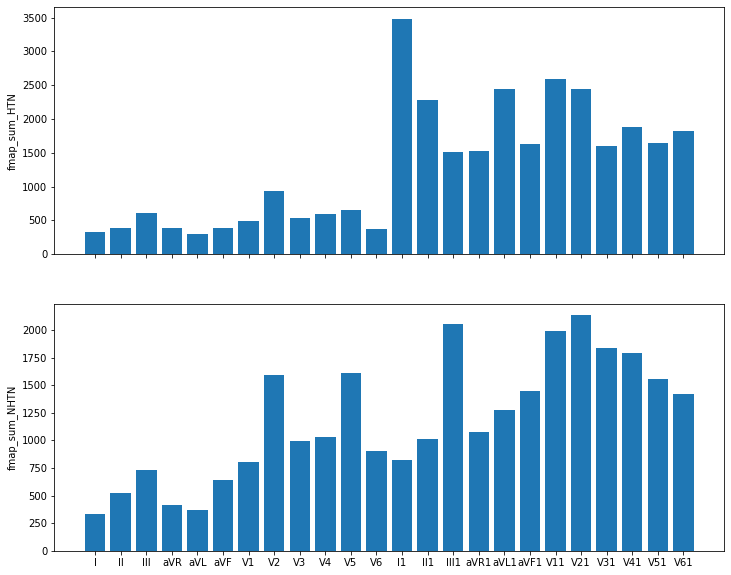

In [37]:
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(nrows = 2,ncols = 1,figsize=(12,10) ,sharex=True)  # type: ignore

leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6','I1', 'II1', 'III1', 'aVR1', 'aVL1', 'aVF1', 'V11', 'V21', 'V31', 'V41', 'V51', 'V61',]
counts = branch_fmap_sum_HTN[:24].tolist()
ax0.bar(leads, counts)
ax0.set_ylabel('fmap_sum_HTN')

counts = branch_fmap_sum_NHTN[:24].tolist()
ax1.bar(leads, counts)
ax1.set_ylabel('fmap_sum_NHTN')
plt.show()

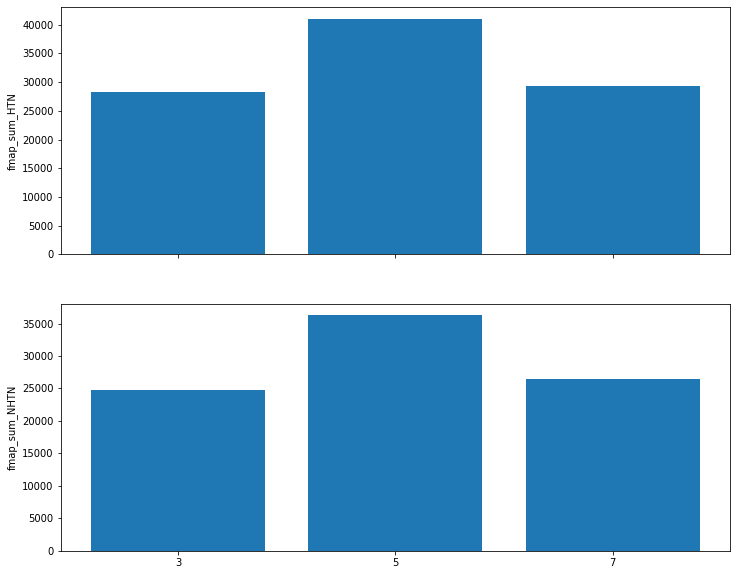

In [38]:
fig, (ax0, ax1) = plt.subplots(nrows = 2,ncols = 1,figsize=(12,10) ,sharex=True)  # type: ignore

leads = ['3', '5', '7']
counts = branch_fmap_sum_HTN[24:].tolist()
ax0.bar(leads, counts)
ax0.set_ylabel('fmap_sum_HTN')

counts = branch_fmap_sum_NHTN[24:].tolist()
ax1.bar(leads, counts)
ax1.set_ylabel('fmap_sum_NHTN')
plt.show()

layer cam

In [39]:
NET = [Net.MLBFNet(num_class= 2,mark=True,res = True,se = True,Dropout_rate = 0.25) ] # type: ignore
testmodel = NET[0].to(DEVICE)
testmodel.load_state_dict(torch.load(Models_path))

<All keys matched successfully>

In [40]:
testmodel.eval()
# 定义获取梯度的函数
fmap_block = list()
grad_block = list()

# 获取反向的传播图
def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

# 定义获取特征图的函数
def farward_hook(module, input, output):
    fmap_block.append(output)

In [41]:
testmodel.conv3.register_forward_hook(farward_hook)	#正向传播
testmodel.conv3.register_full_backward_hook(backward_hook)#反向传播

In [42]:
def plot_top_attention_points(fig,axs,x,y,color_depend,cmap = "jet",y_name = "Voltage(mV)",title="",top_num = 100):
    axs.plot(x,y, color='black',linewidth=0.5)
    
    top_idx=color_depend.argsort()[::-1][0:top_num]
    axs.scatter(top_idx, y[top_idx],s=2,c='r')
    #fig.colorbar(line, ax=axs)
    axs.set_xlim(x.min(), x.max())
    axs.set_ylim(-3500, +3500)

    axs.set_aspect(0.2)#用于设置轴缩放的方面，即y-unit与x-unit的比率
    axs.xaxis.set_major_locator(plt.MultipleLocator(100))# type: ignore # 100*0.002s=0.2s = 5格
    axs.xaxis.set_minor_locator(plt.MultipleLocator(20)) # type: ignore # 20*0.002=0.004S = 1格
    axs.yaxis.set_major_locator(plt.MultipleLocator(500))# type: ignore # 0.1uv*500 = 0.5ms = 5格
    axs.yaxis.set_minor_locator(plt.MultipleLocator(100))# type: ignore # 0.1uv*100 =0.1ms = 1格 

    #axs.xaxis.set_major_formatter(plt.NullFormatter()) #x轴不显示刻度值/lable per 0.2s
    axs.xaxis.set_major_formatter(lambda x, pos: str(round(0.2*(x/100.0),2))) #x轴 lable per 0.2s
    axs.yaxis.set_major_formatter(lambda x, pos: str(x/1000.0)) # label per '0.5 mv'，turn uV to mv

    axs.grid(which='major', axis='x', linewidth=0.3, linestyle='-', color='b')
    axs.grid(which='minor', axis='x', linewidth=0.1, linestyle='-', color='b')
    axs.grid(which='major', axis='y', linewidth=0.3, linestyle='-', color='b')
    axs.grid(which='minor', axis='y', linewidth=0.1, linestyle='-', color='b')
    axs.set_ylabel(y_name)
    axs.set_title(title)
    axs.grid(True, which='both')

100%|██████████| 10/10 [03:21<00:00, 20.16s/it]


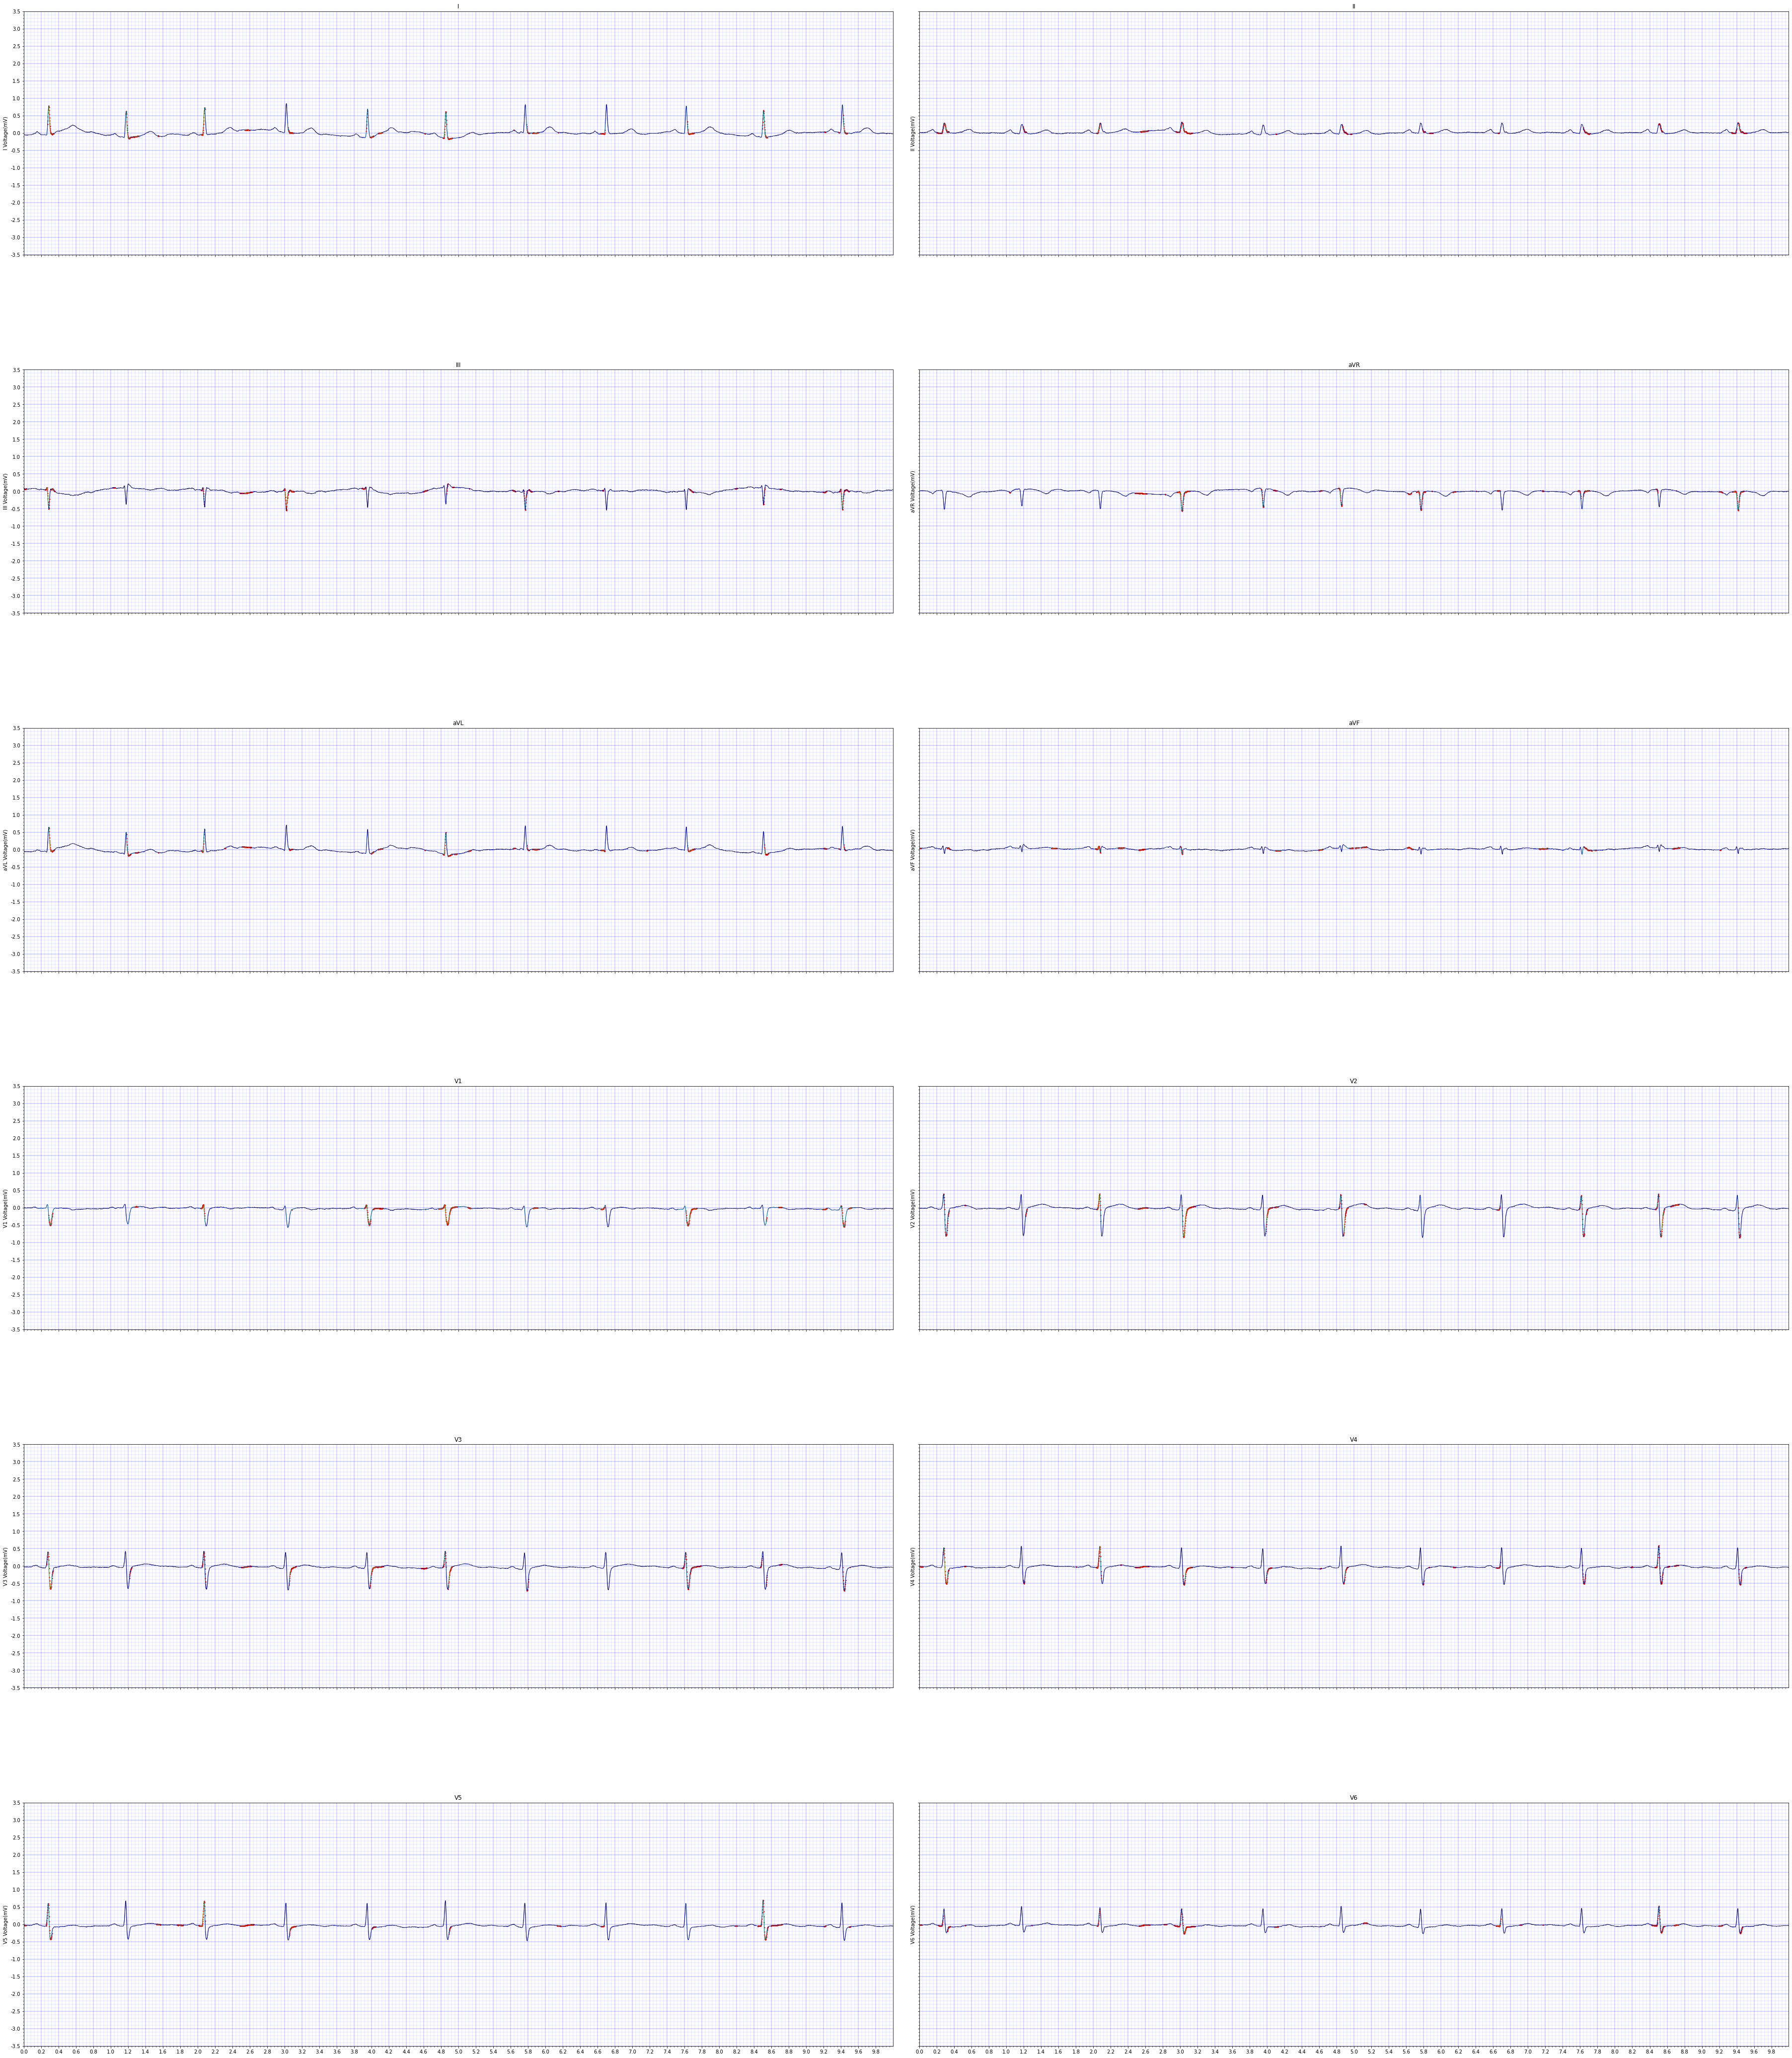

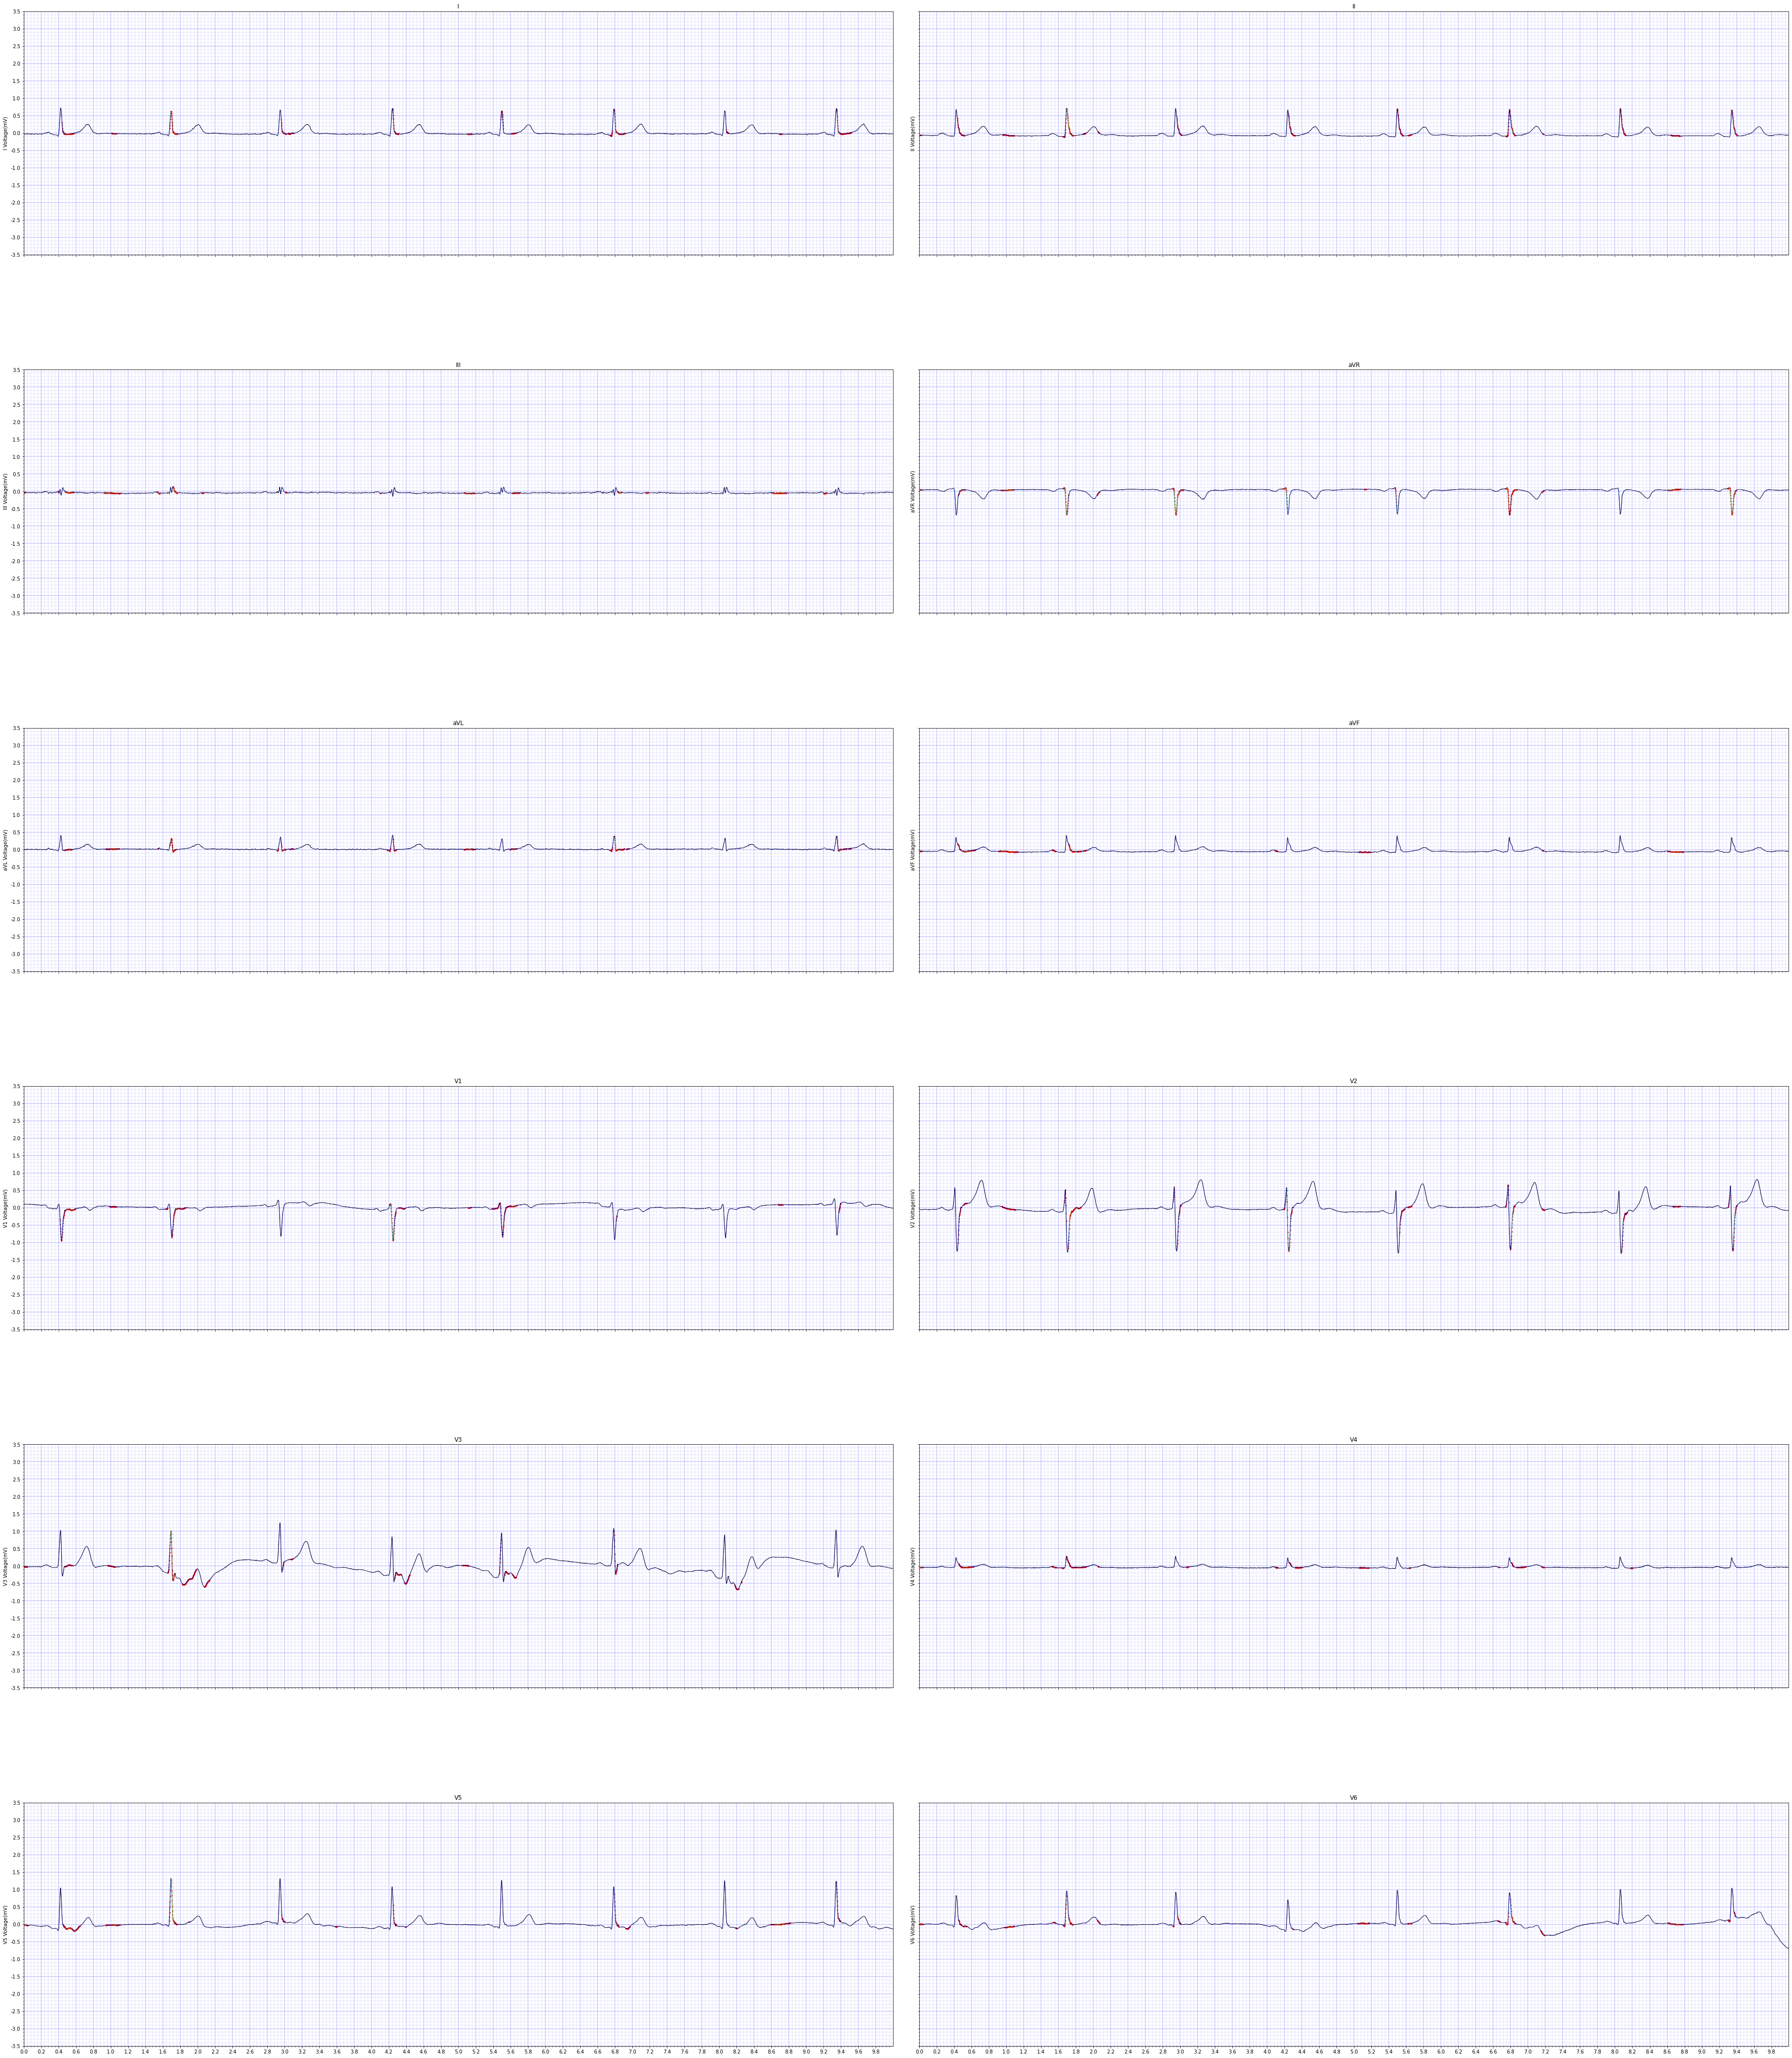

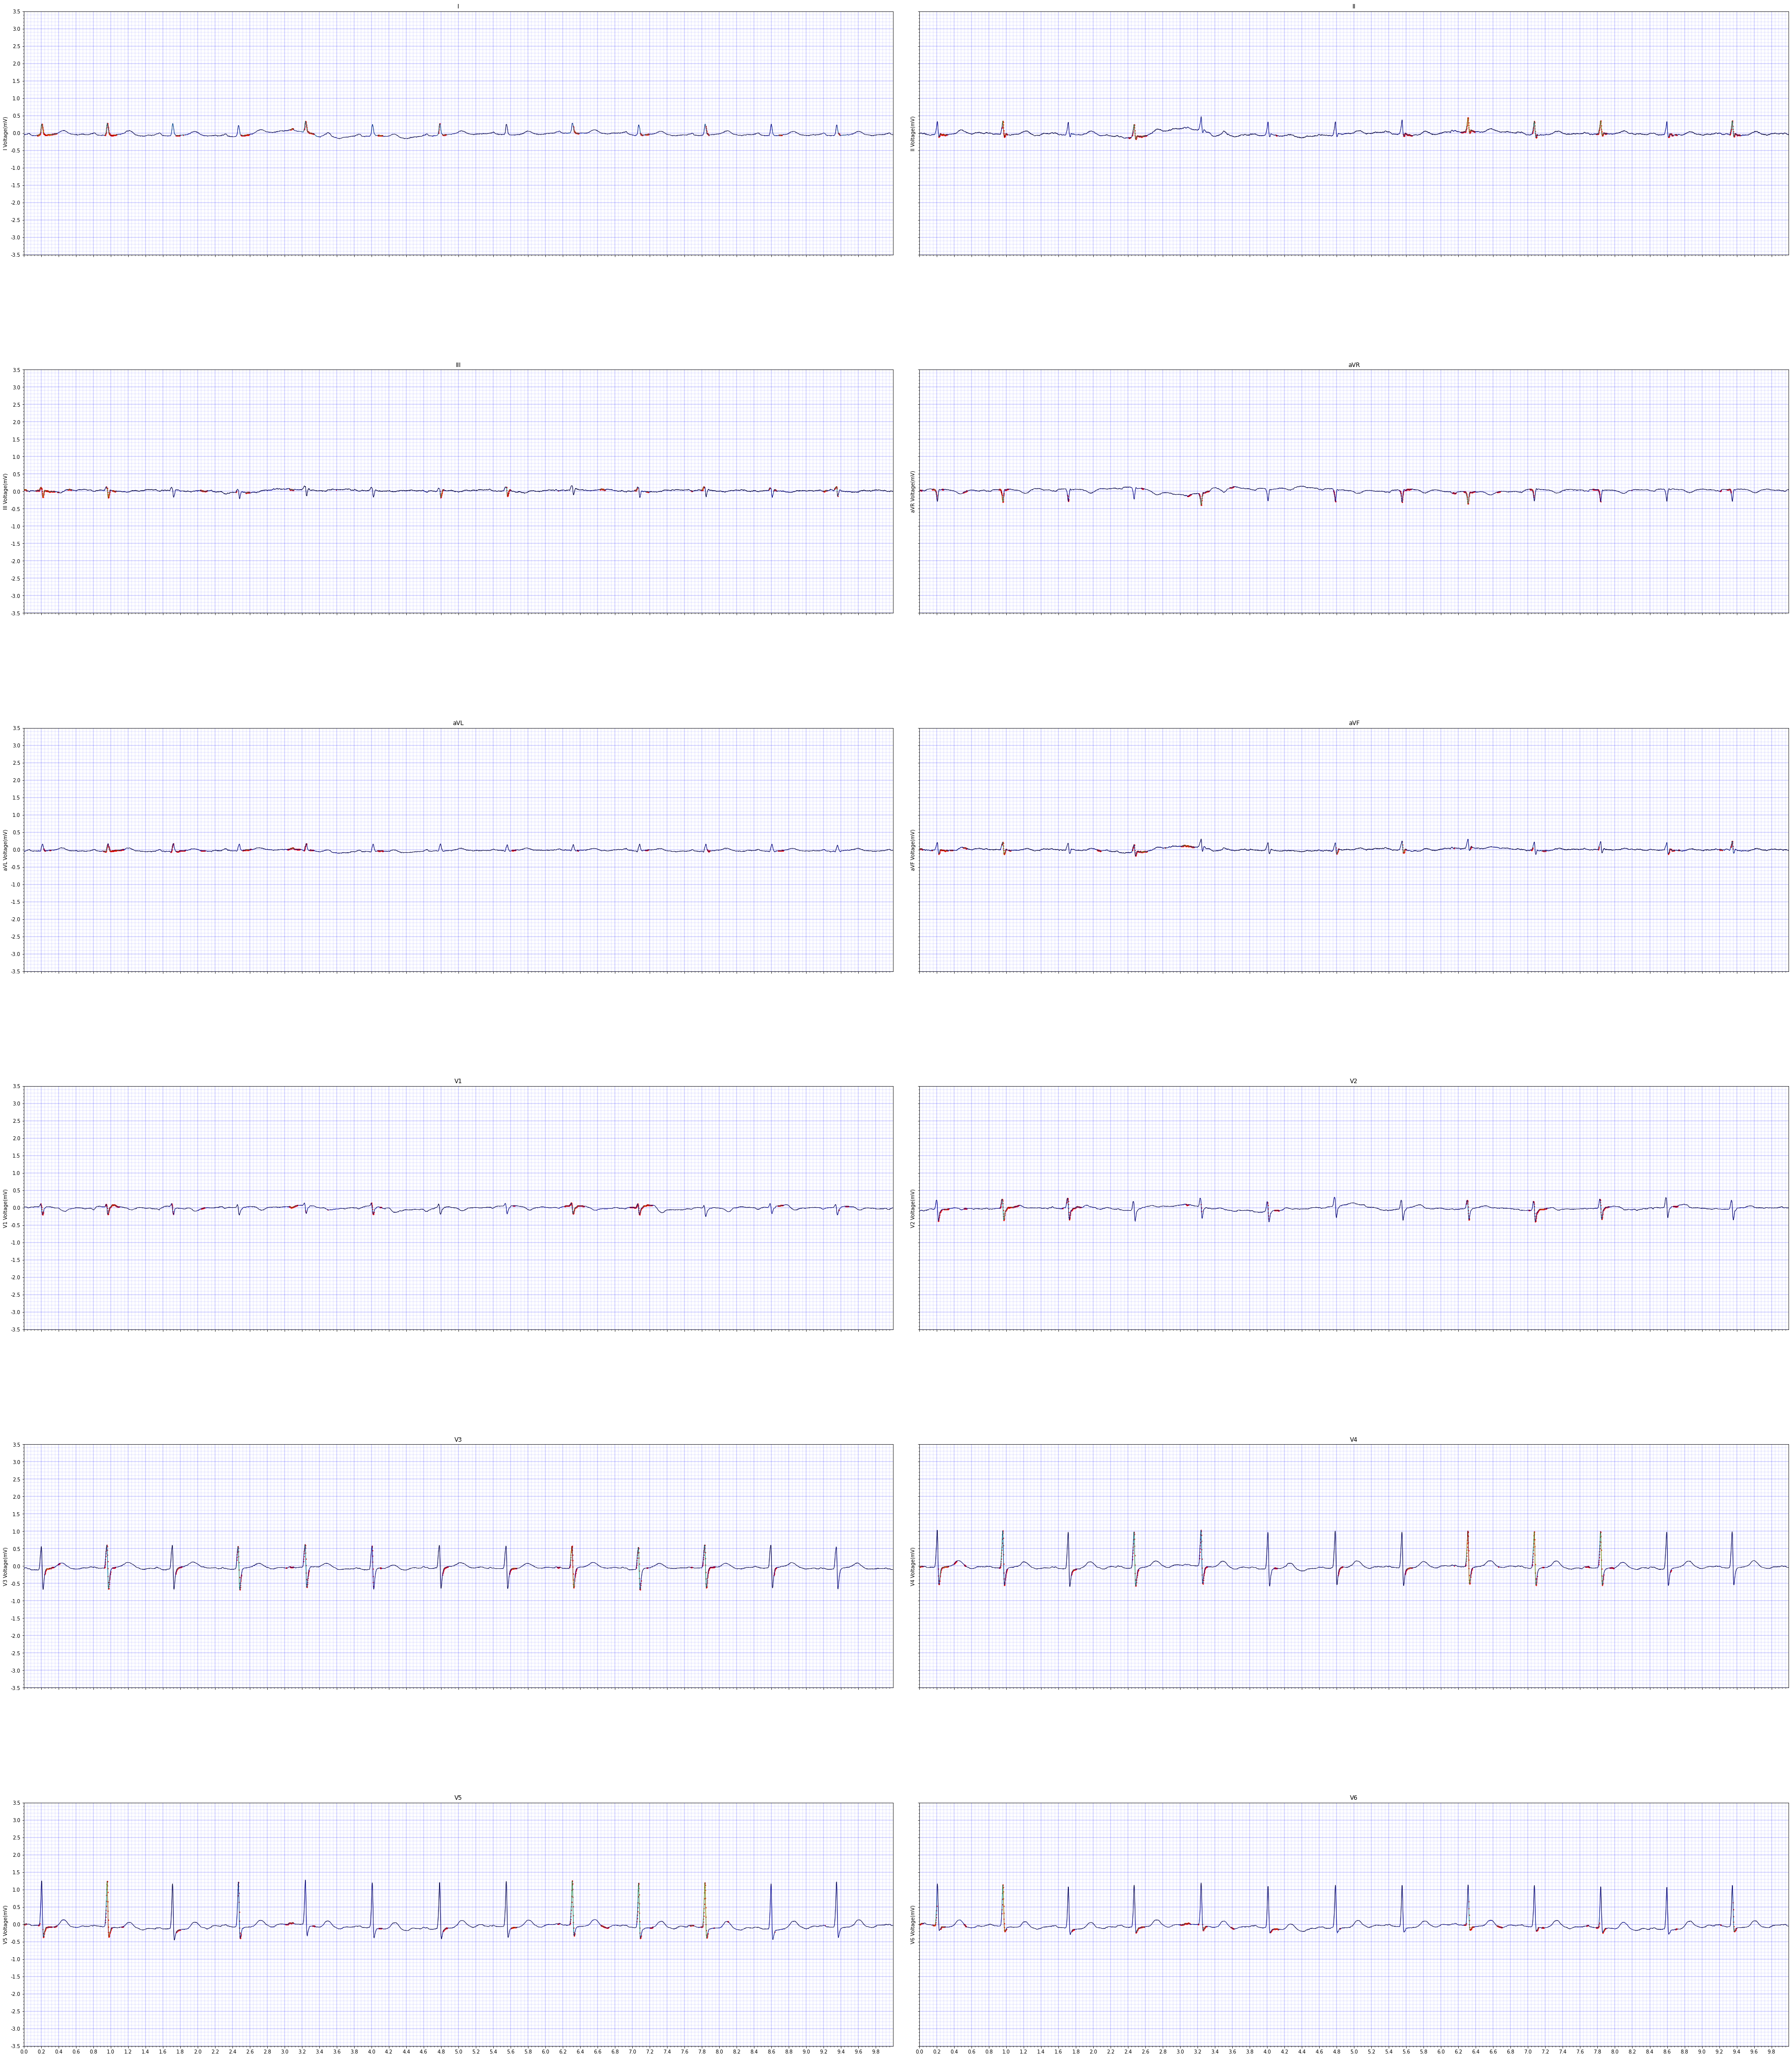

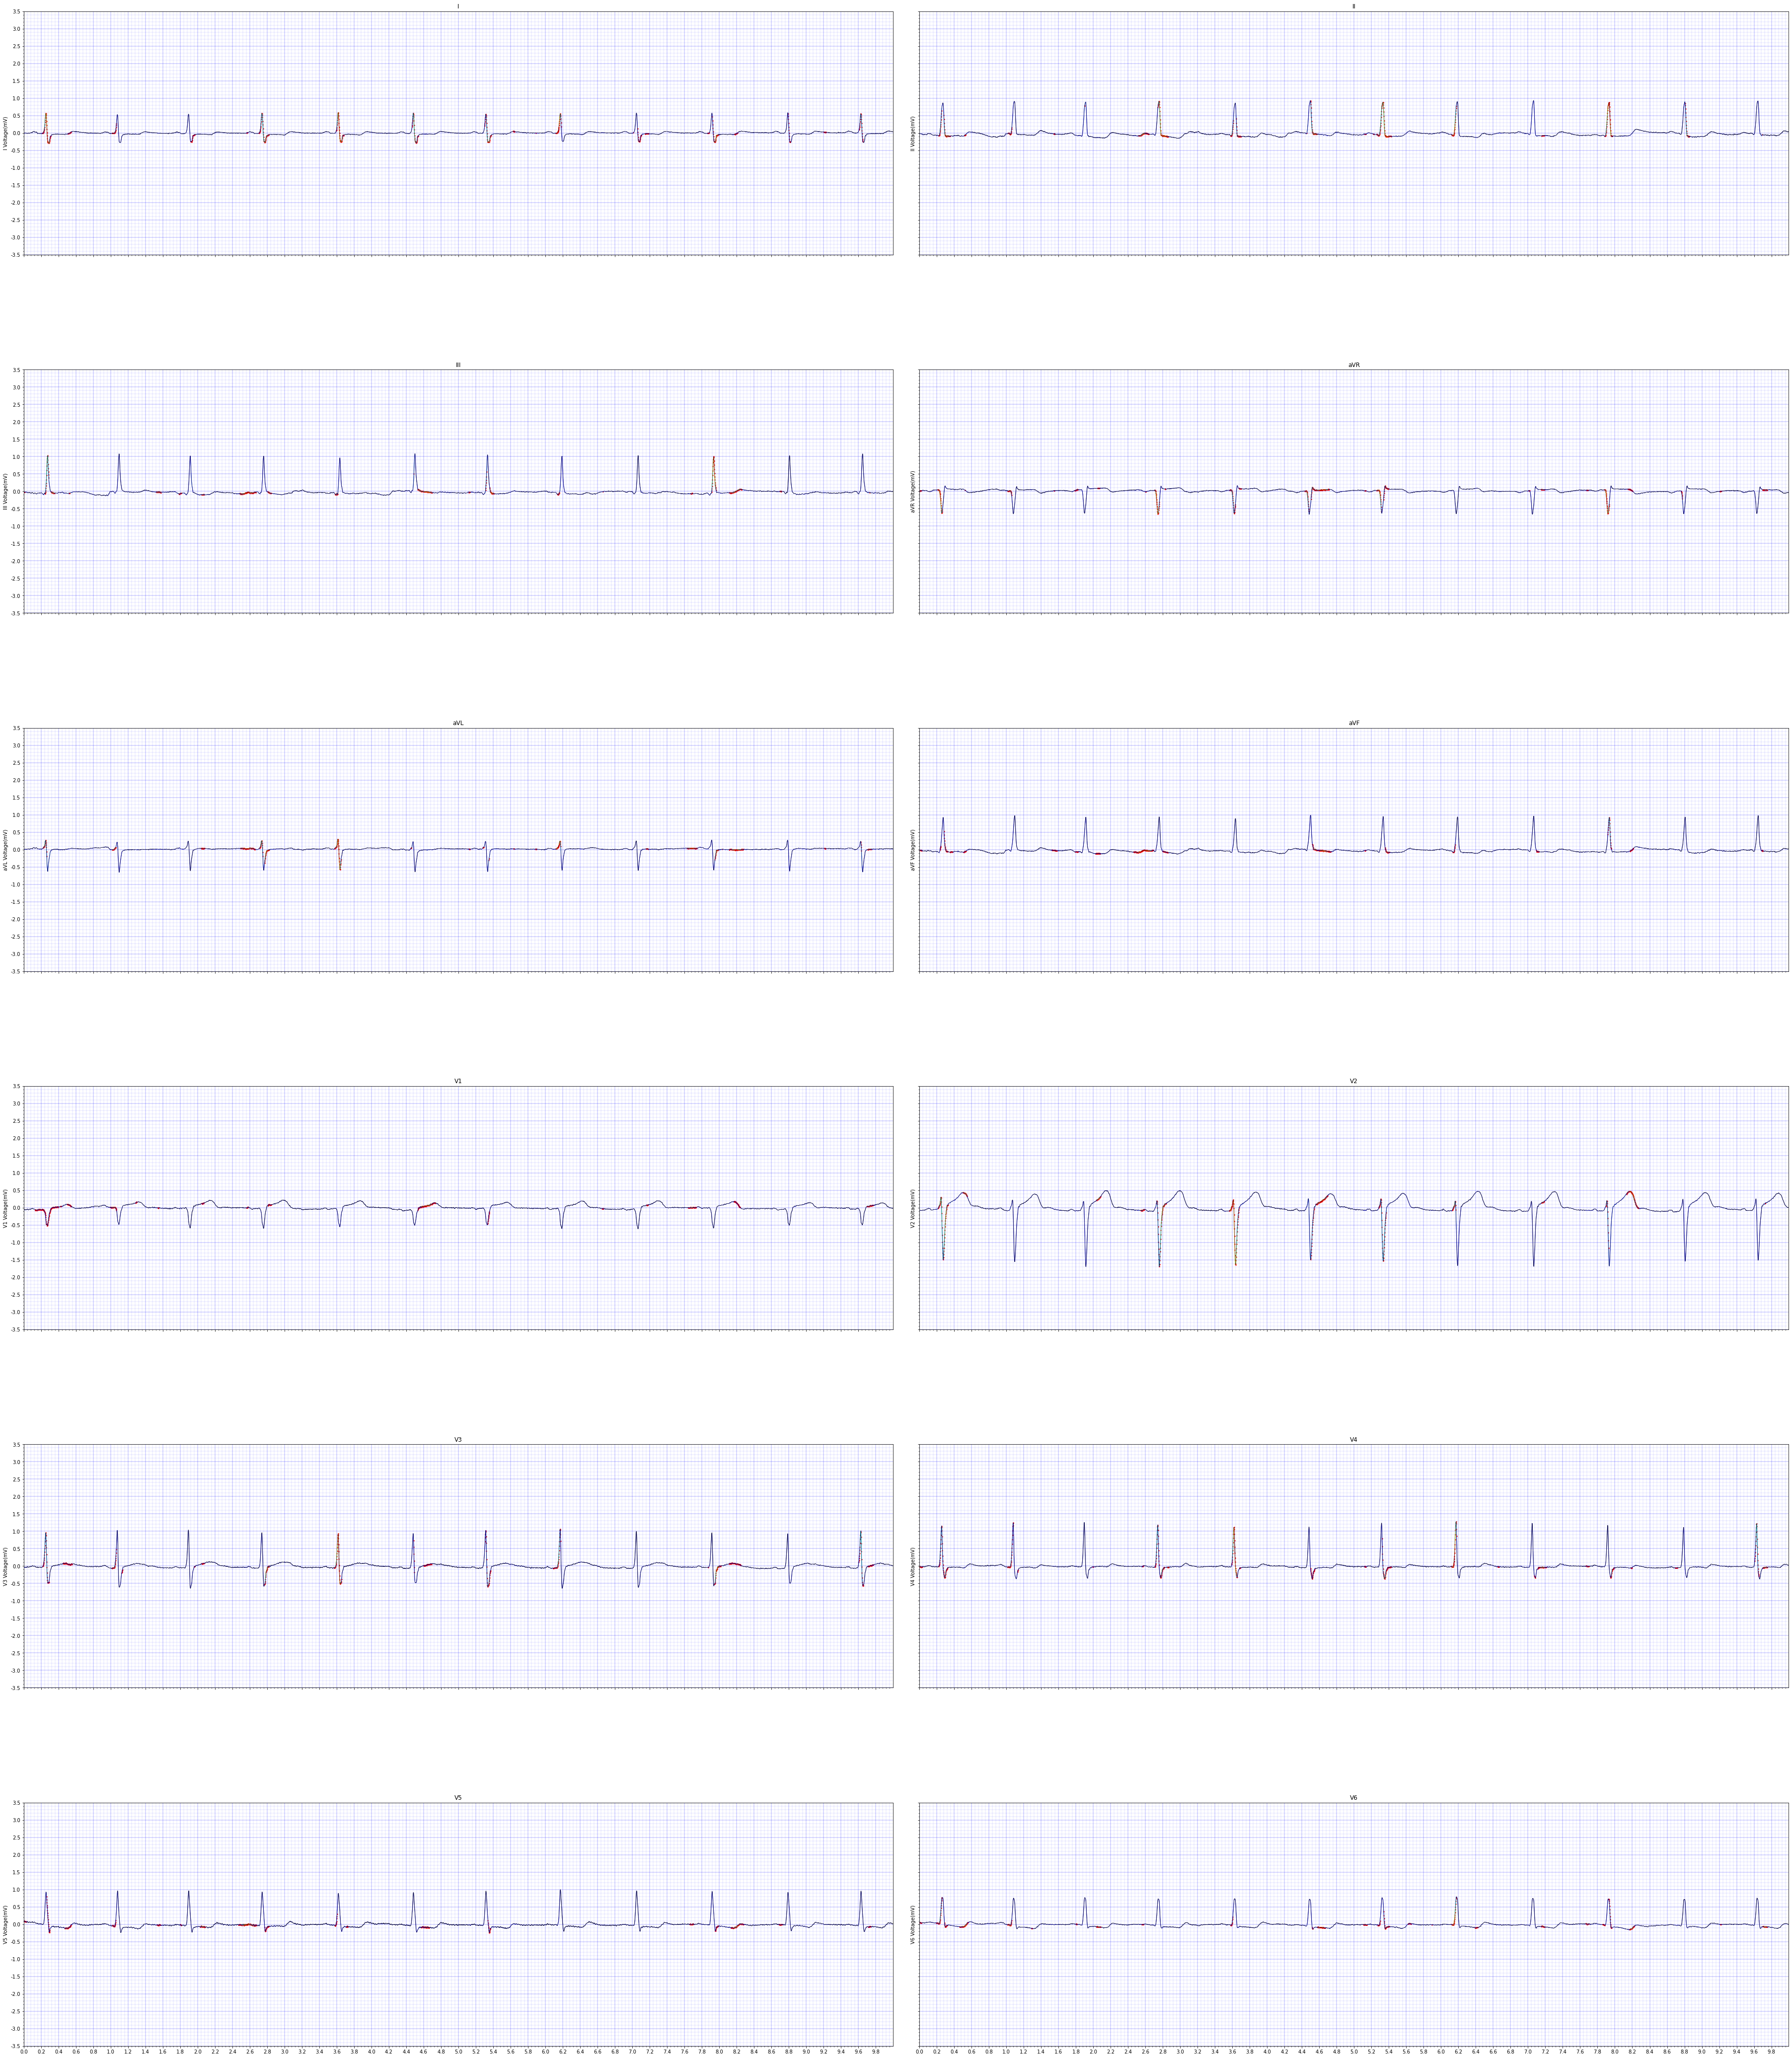

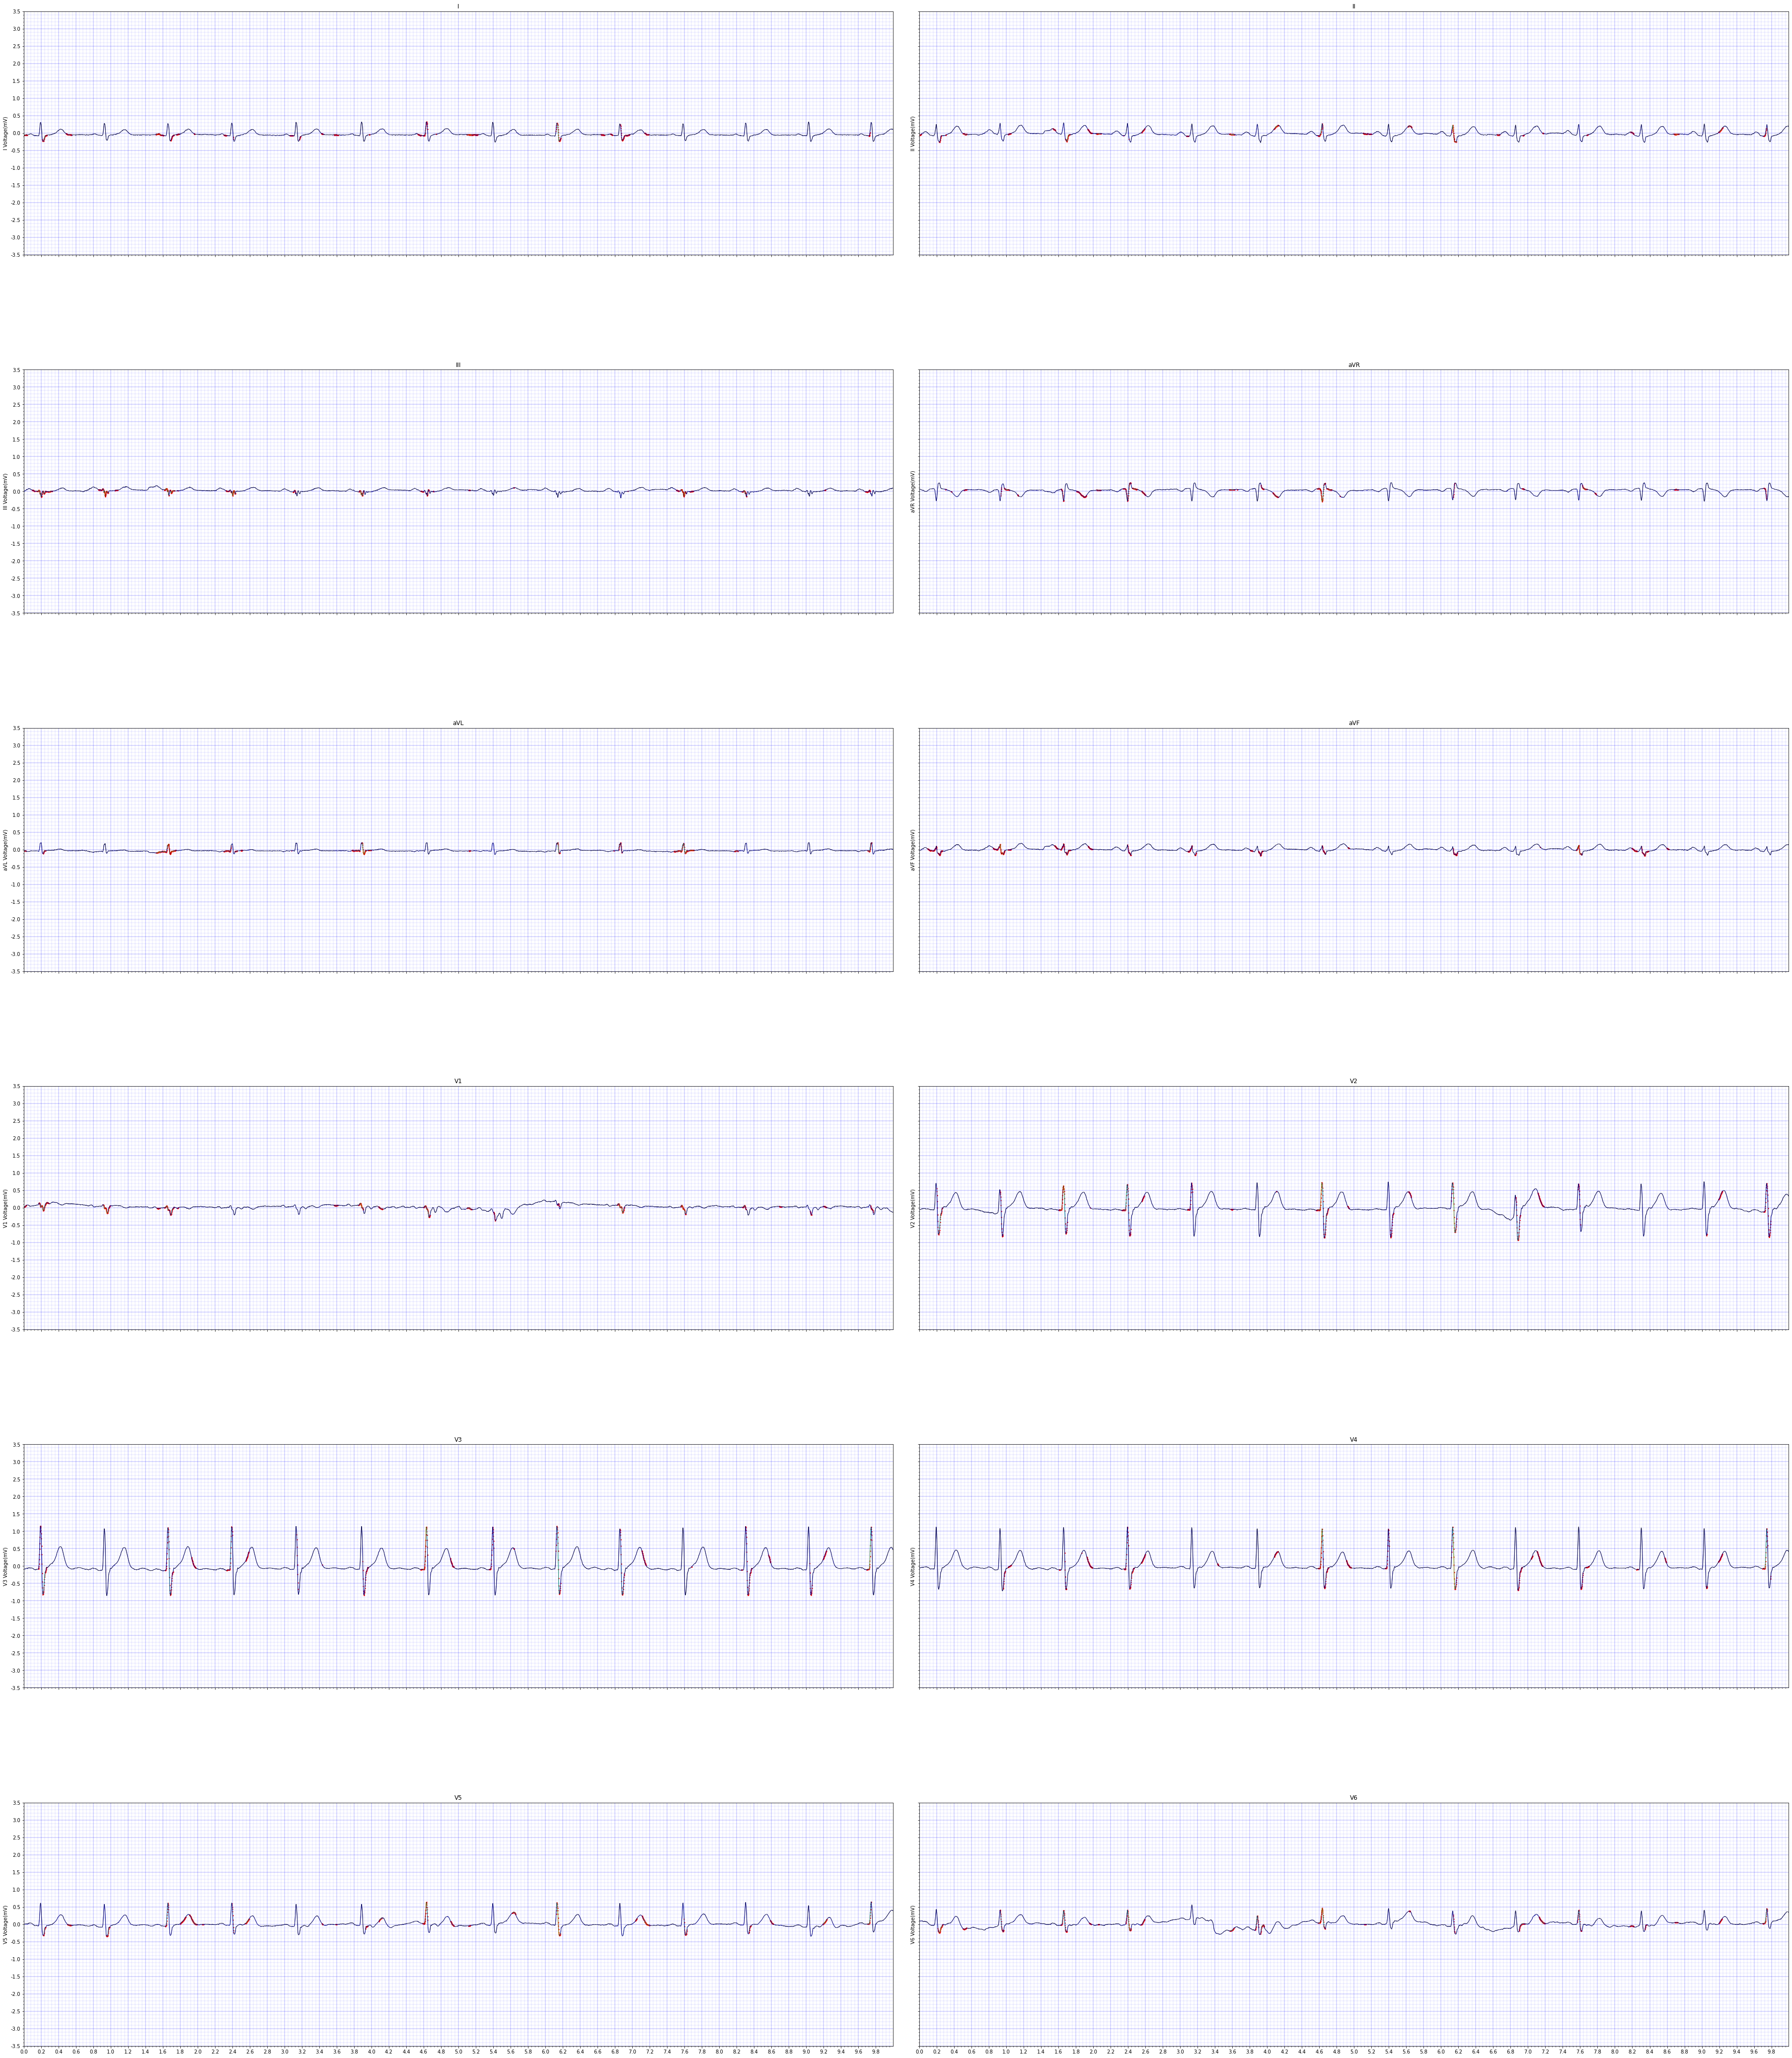

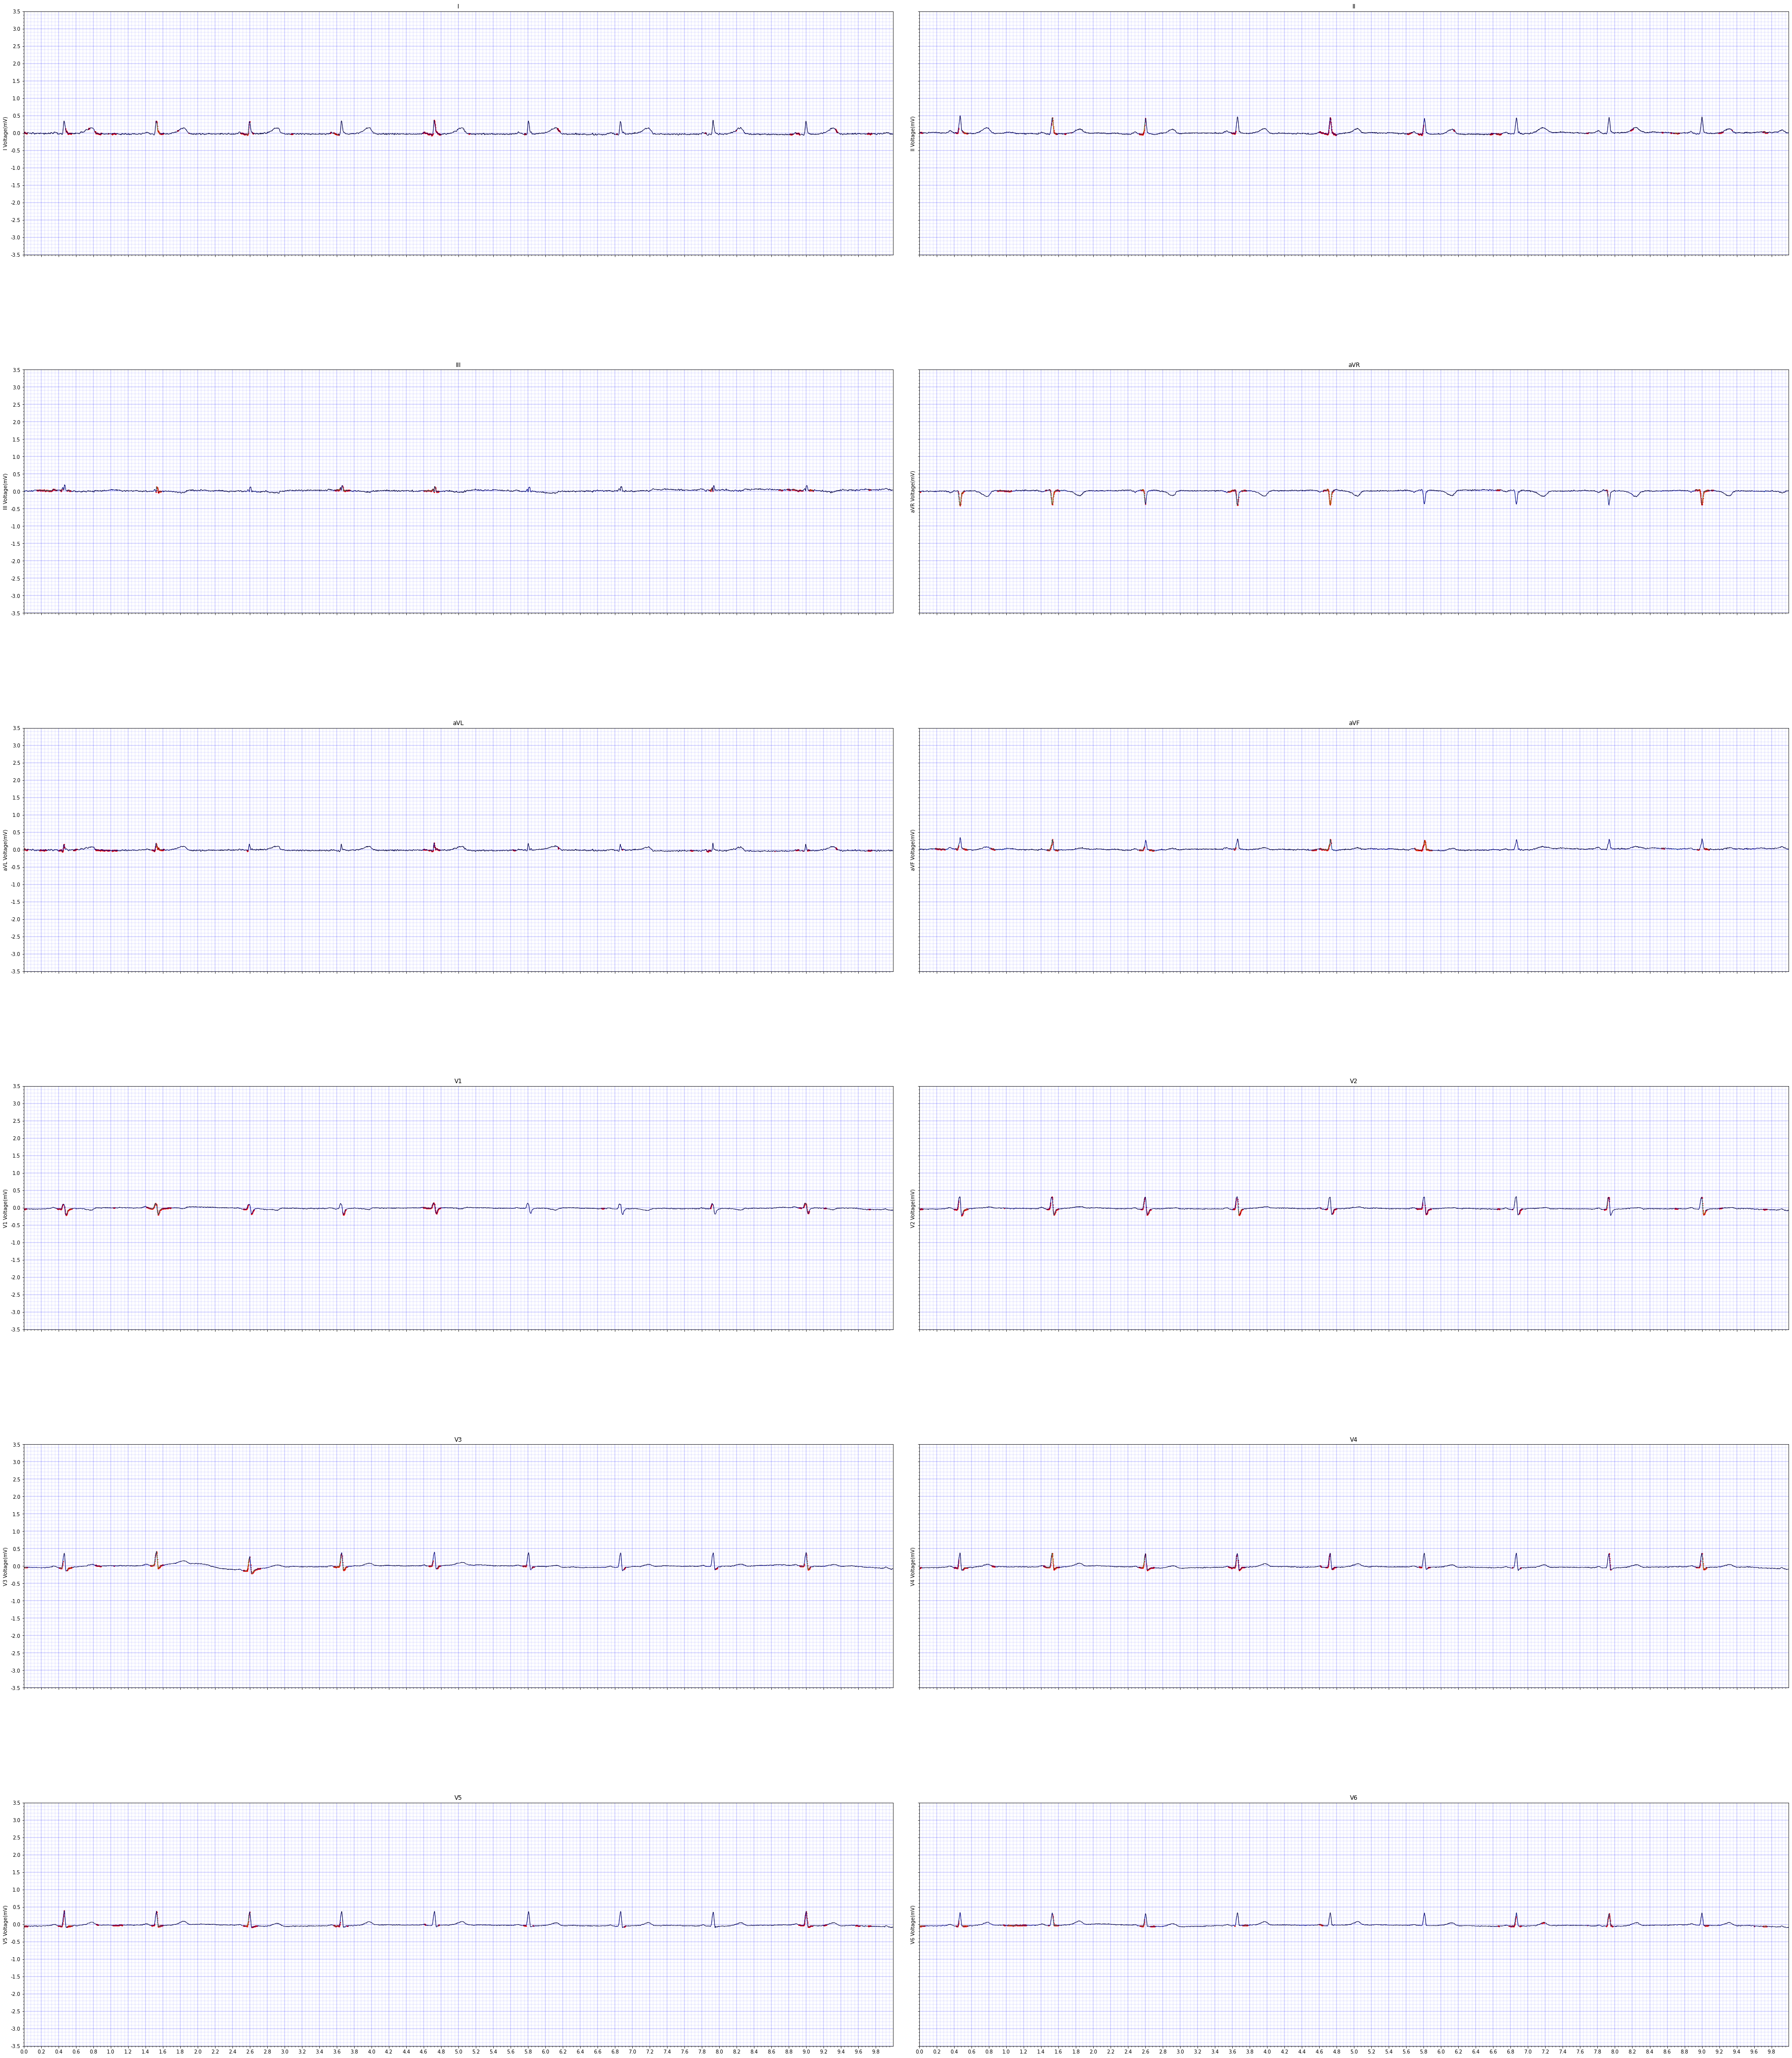

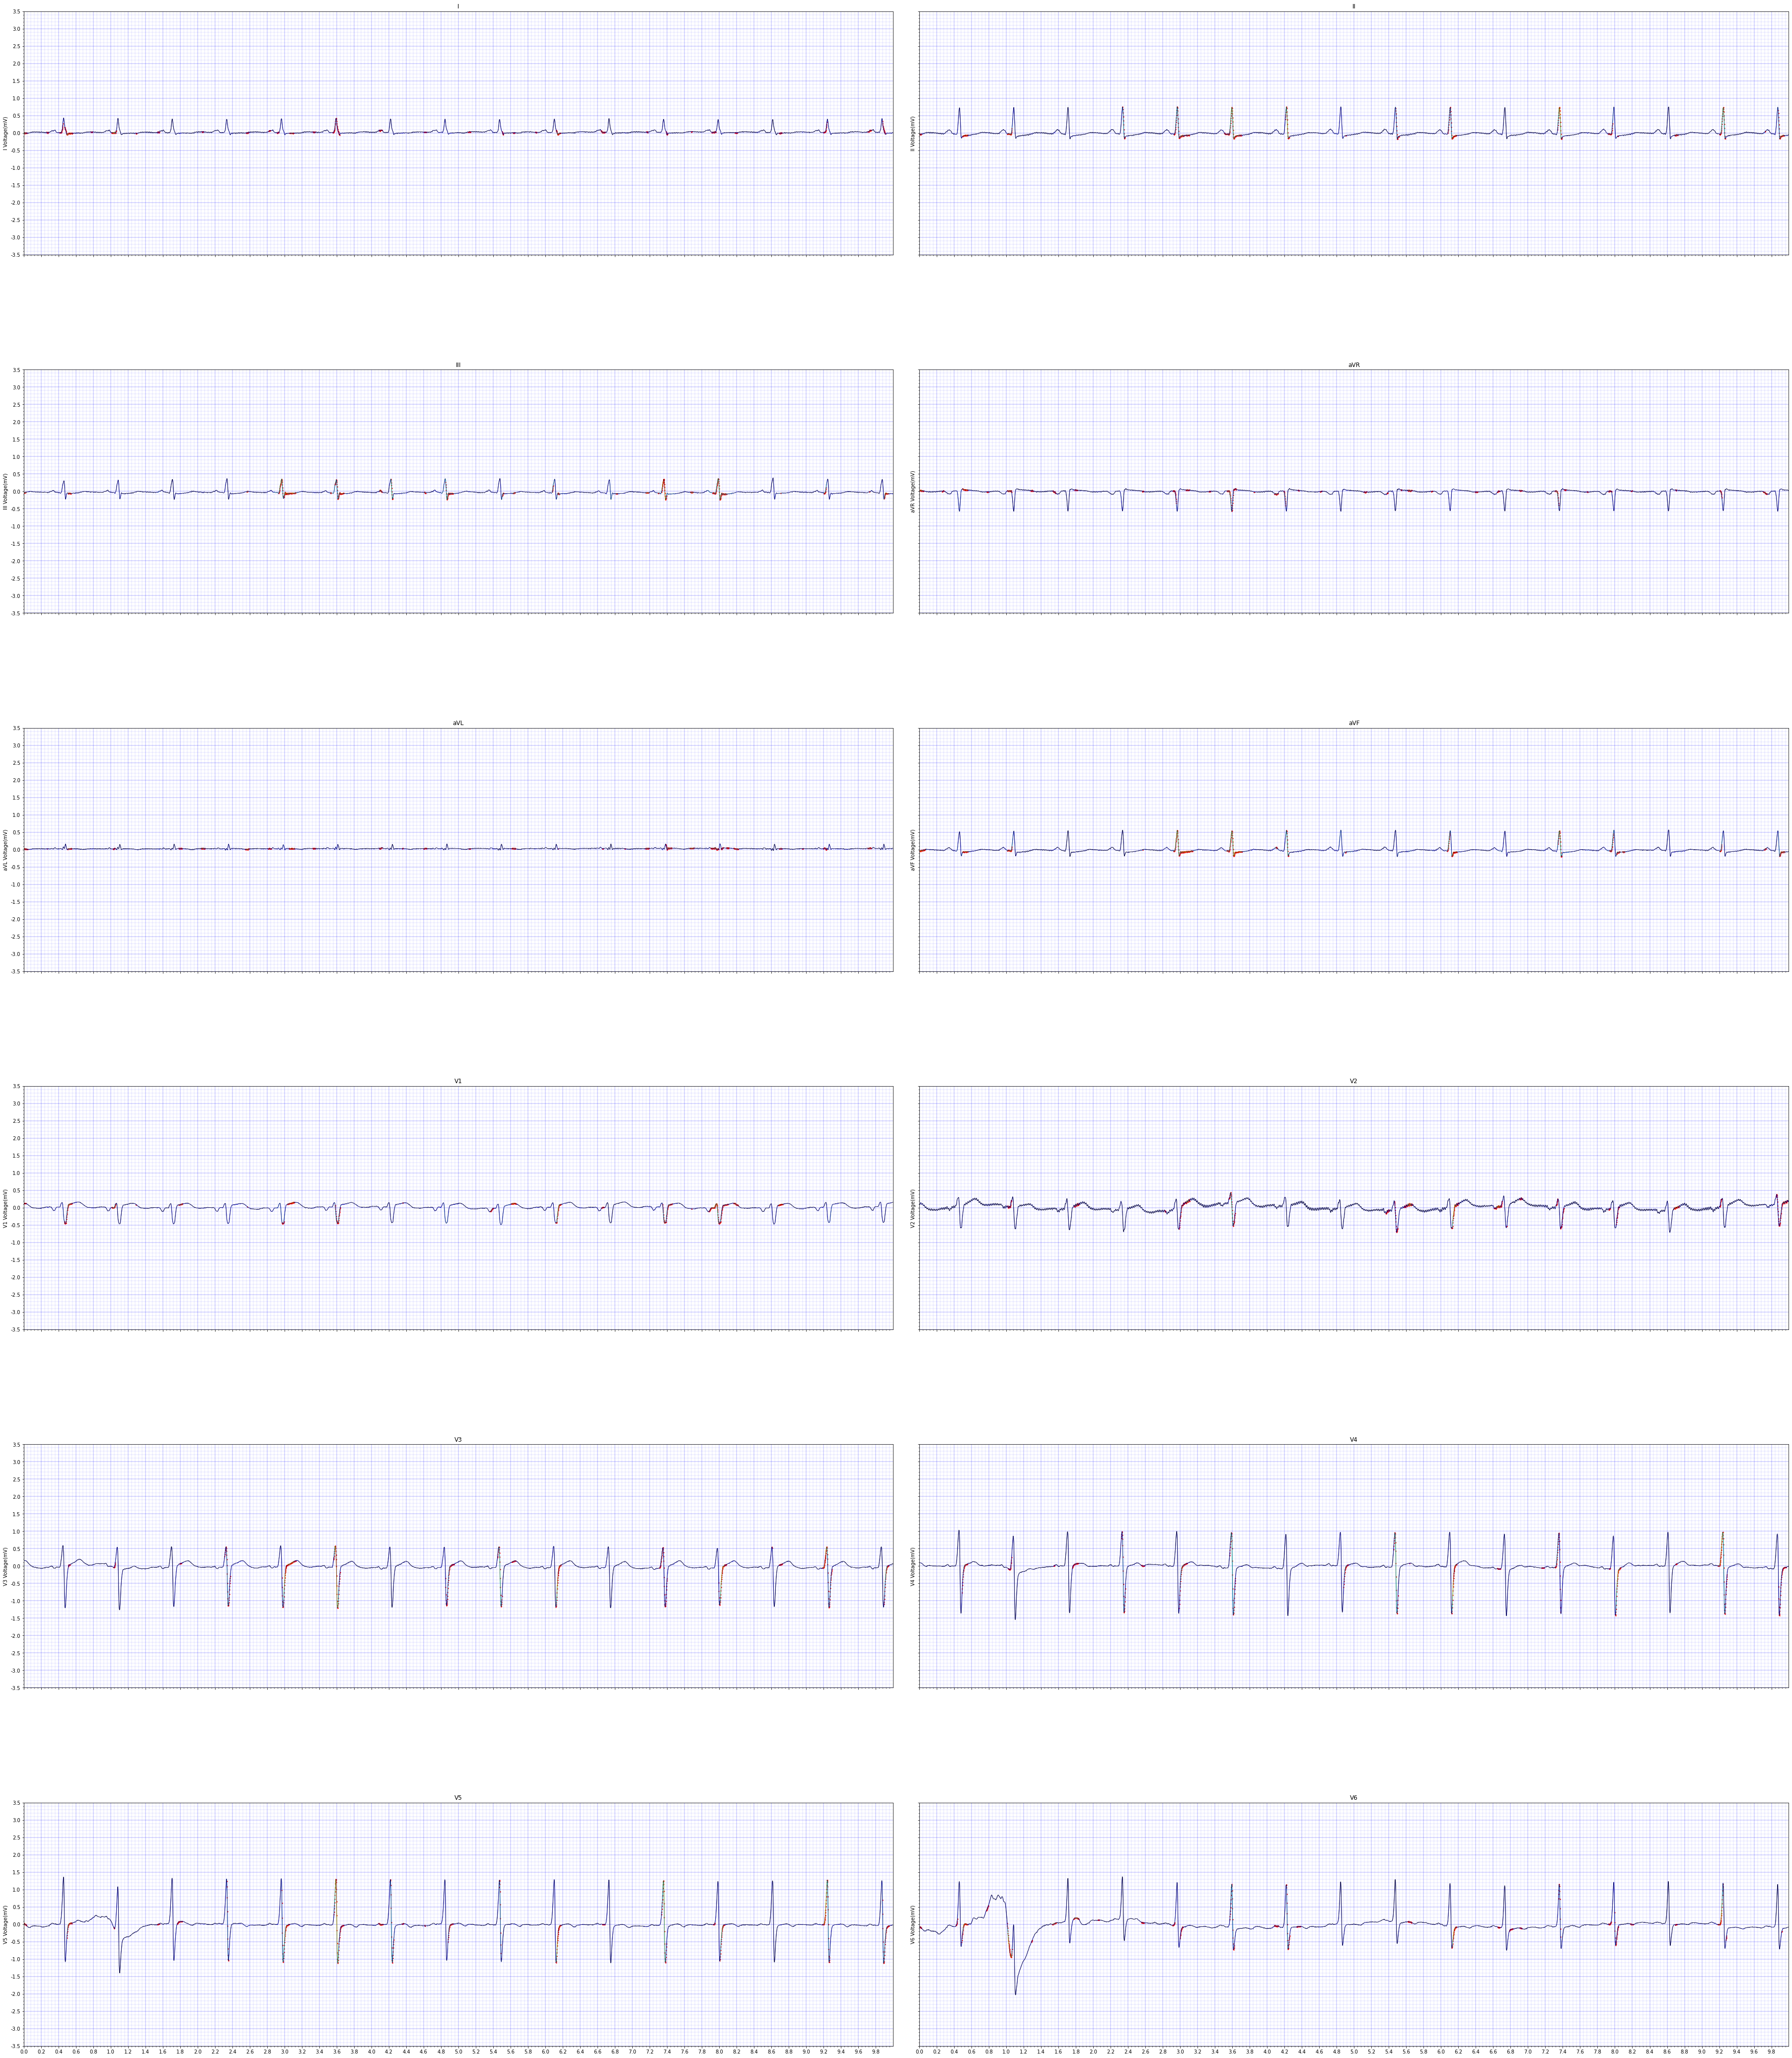

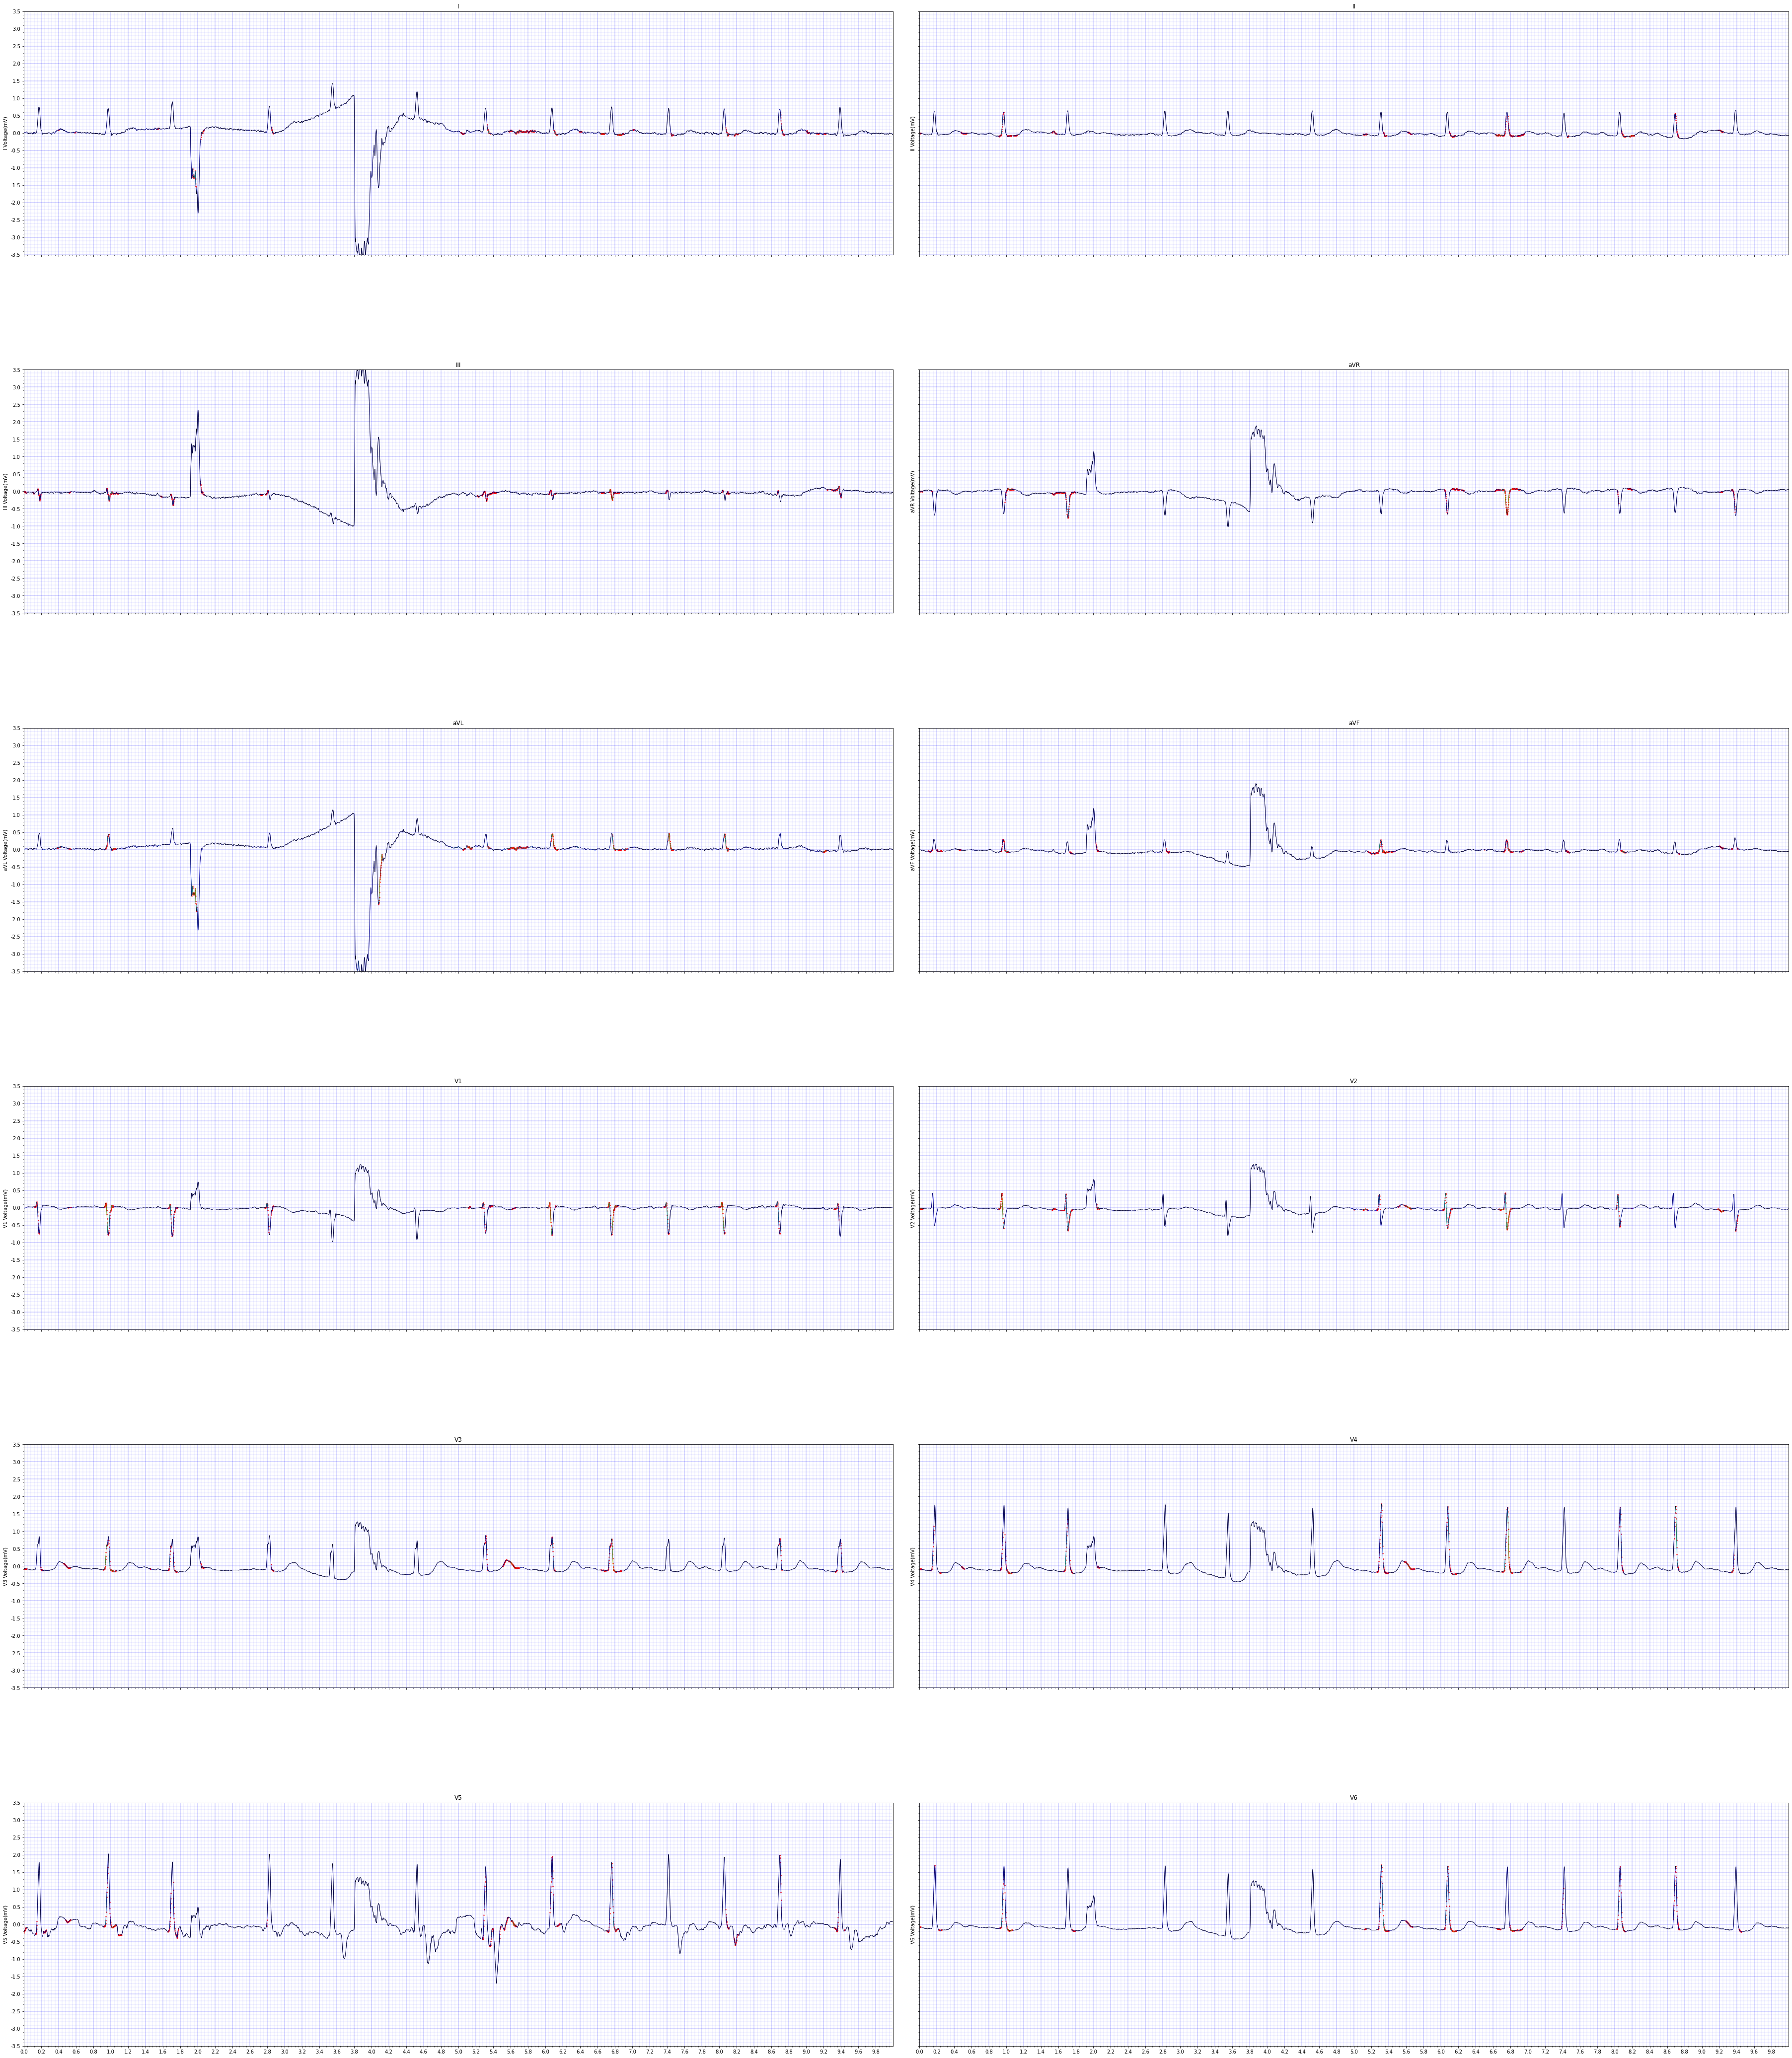

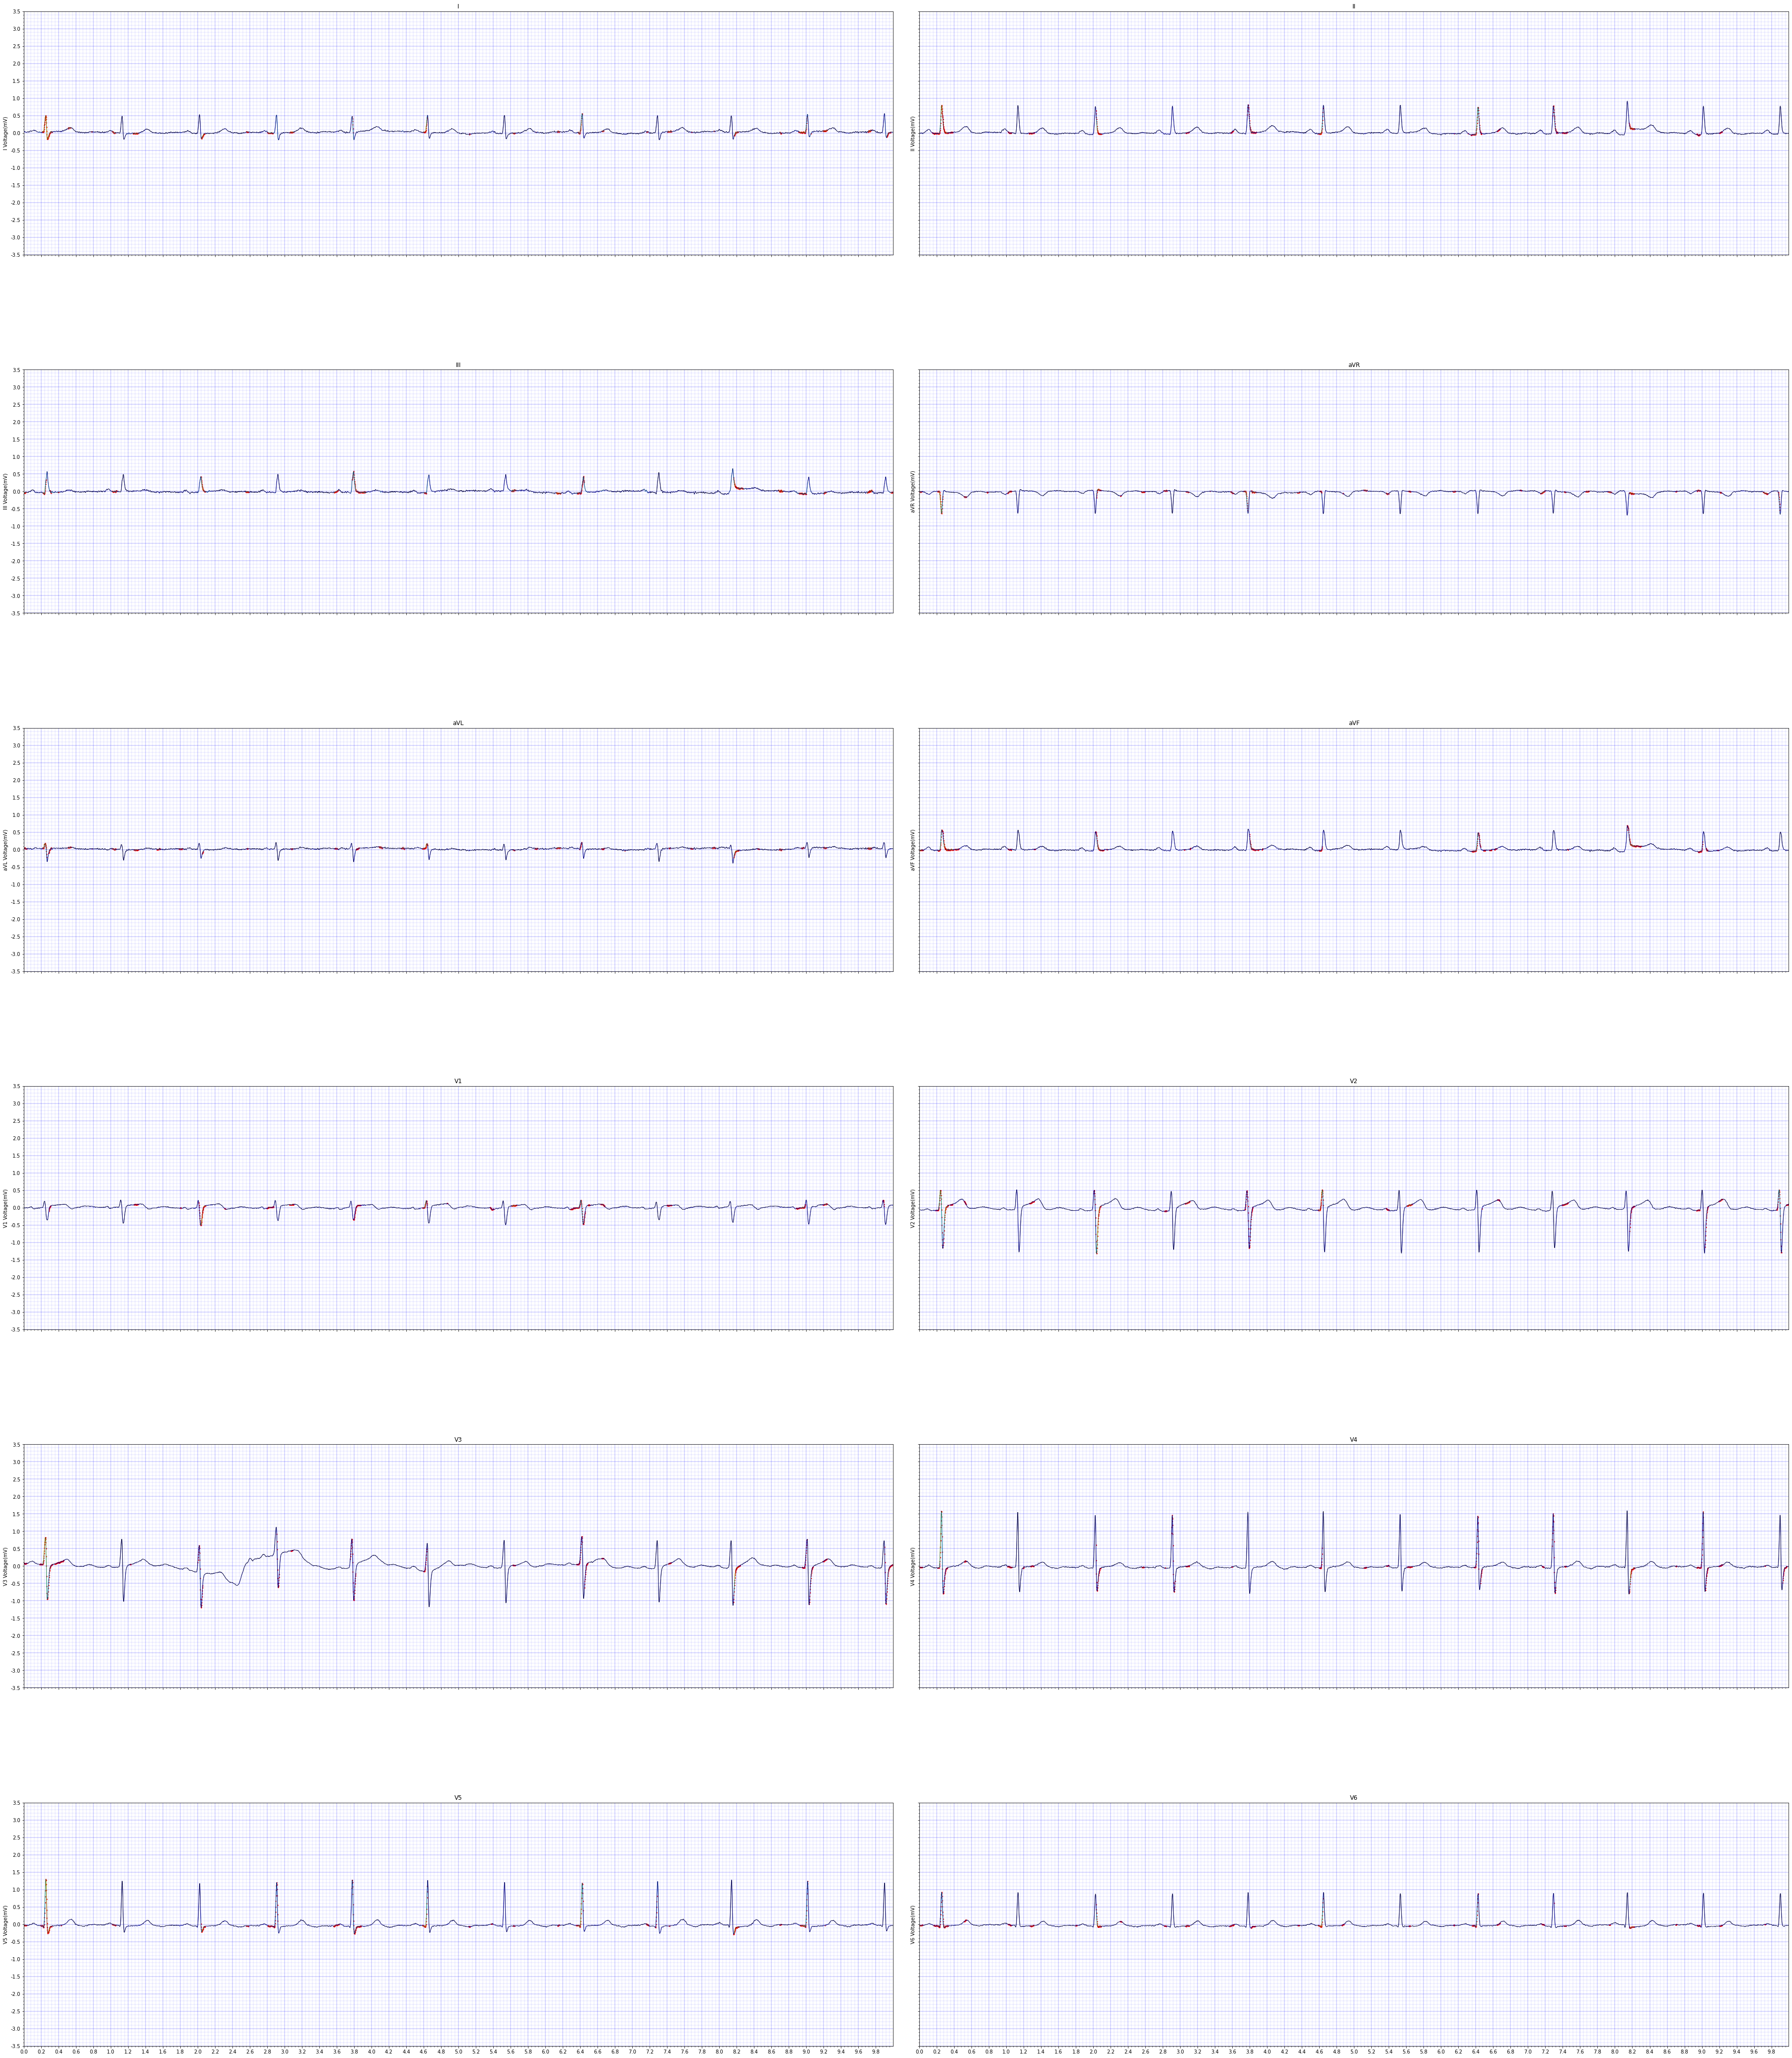

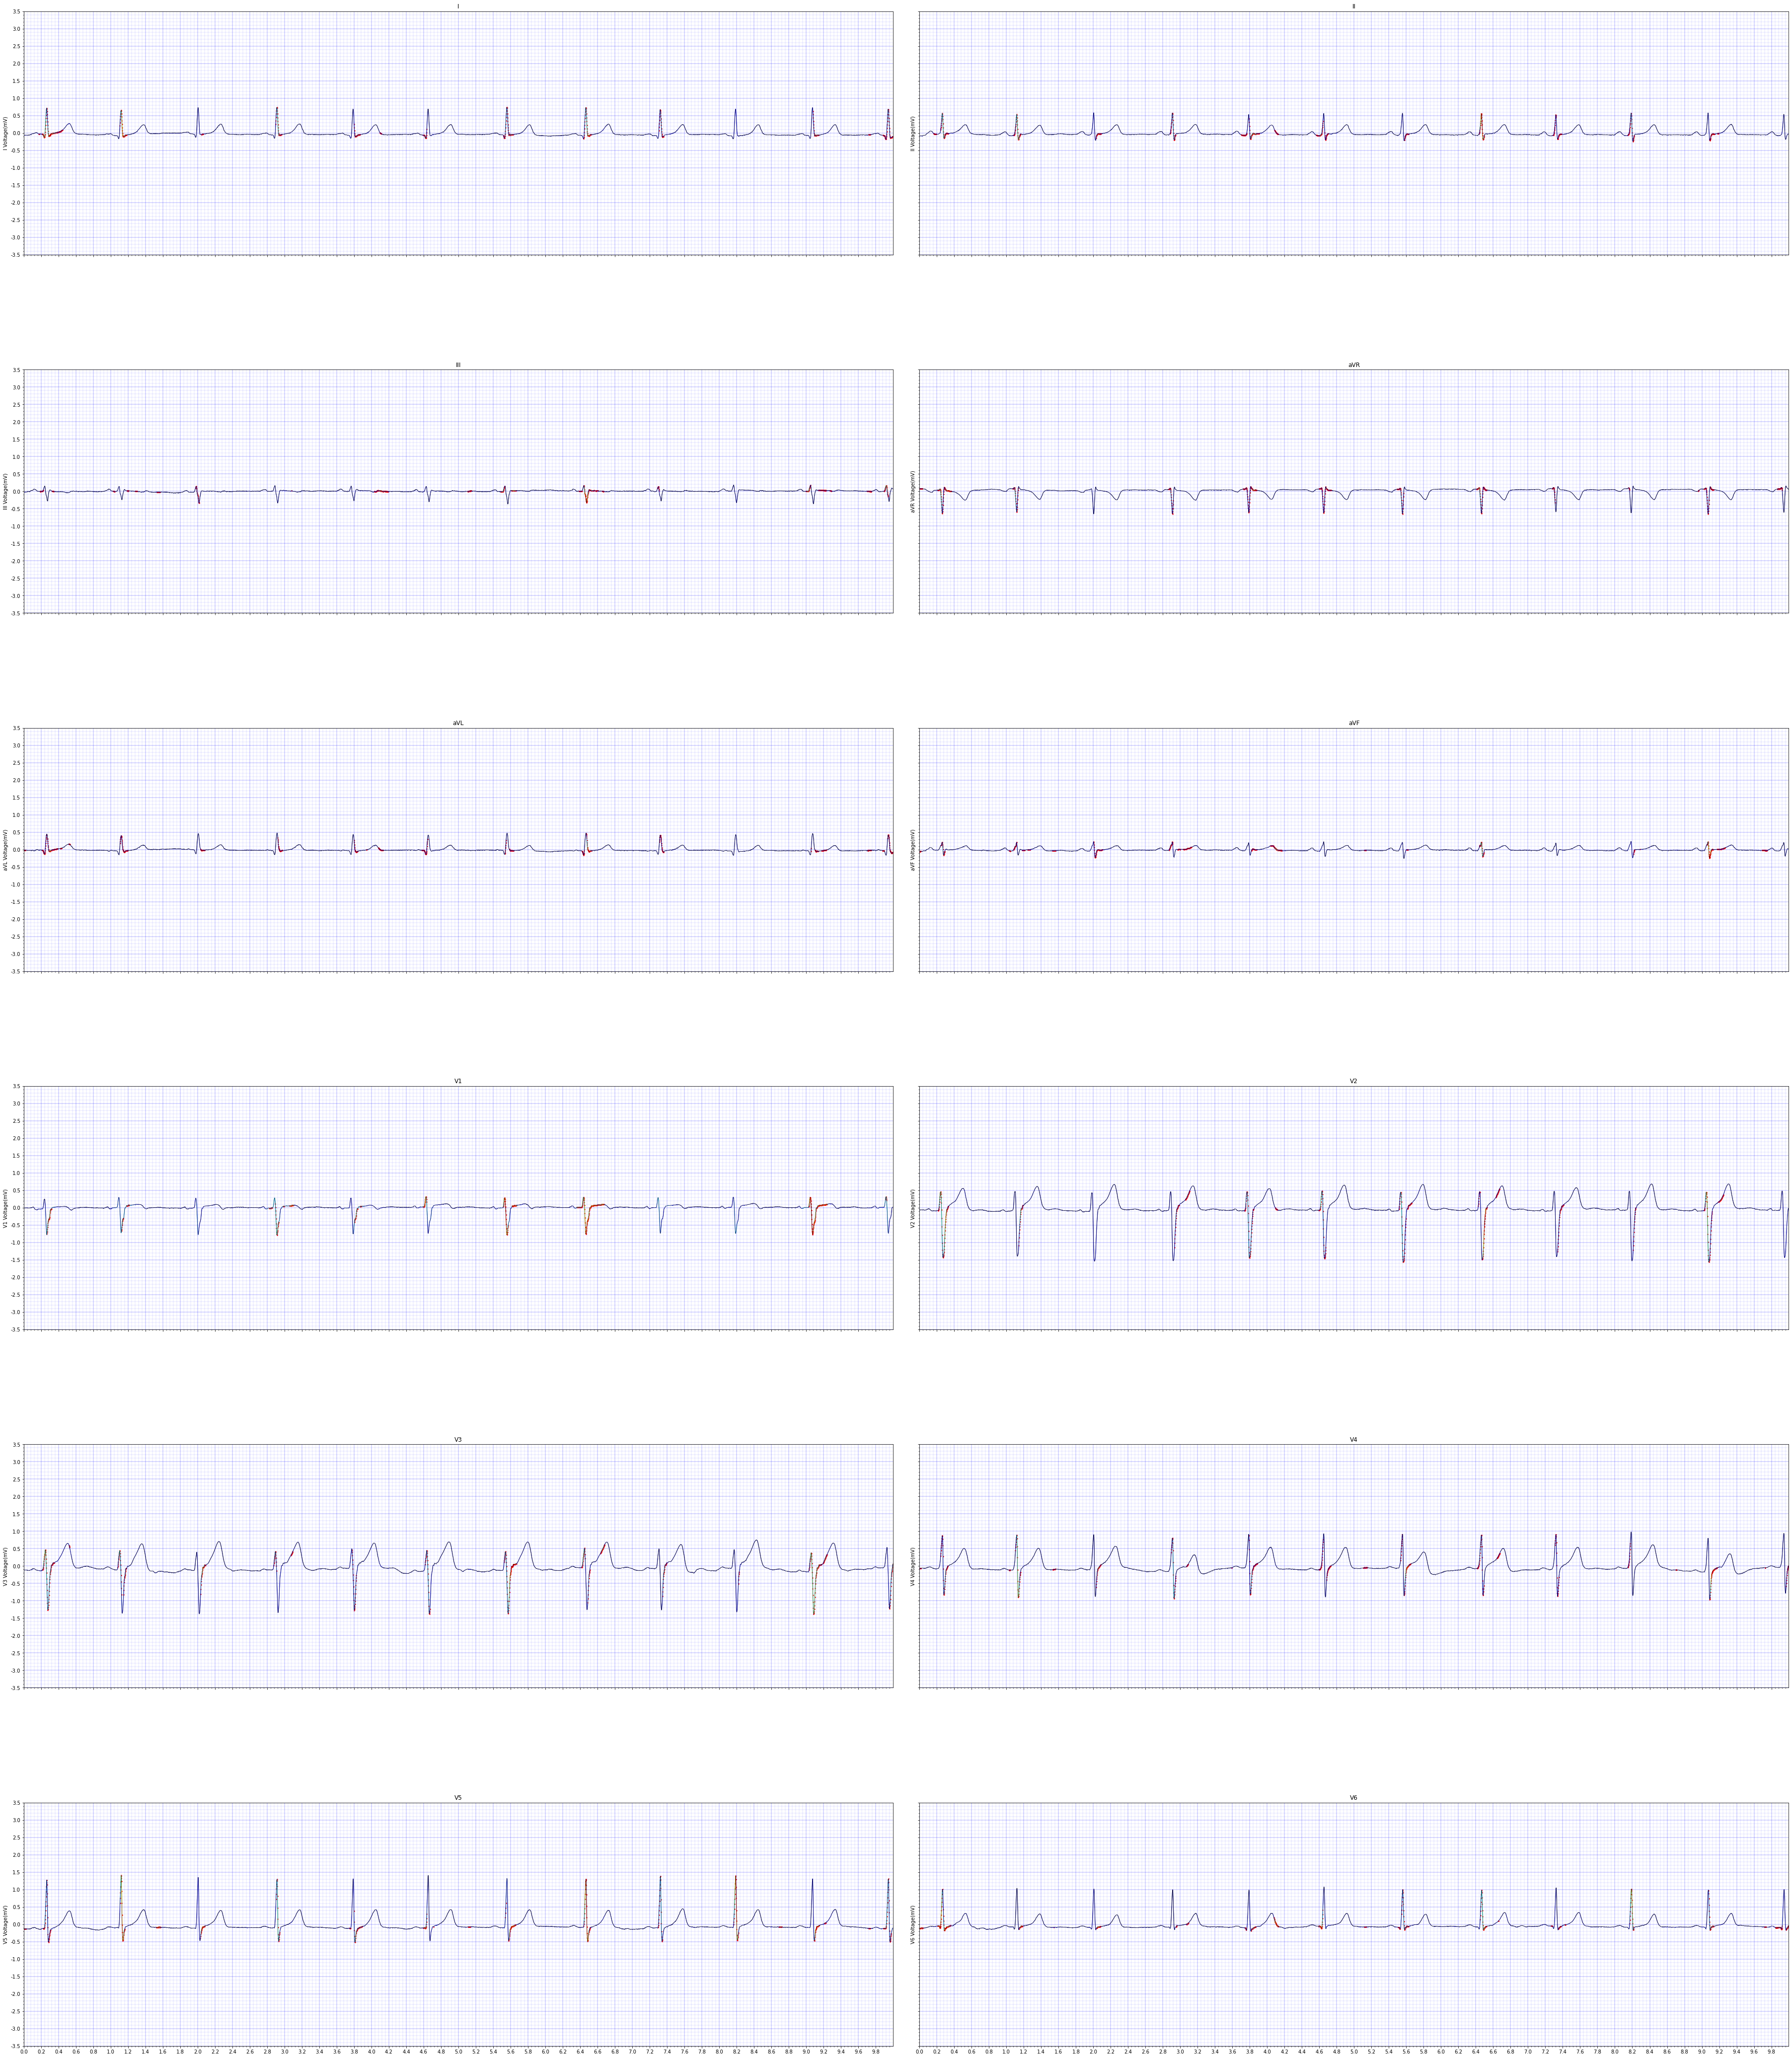

In [43]:
for itme in tqdm(range(10)):
    fmap_block = list()
    grad_block = list()
    inputs,labels = test_dataset.__getitem__(itme)
    ECGFilename = (test_dataset.infos.iloc[itme]['ECGFilename'])
    labels = labels.unsqueeze(0) # 在首位添加1维作为batchsize
    inputs = inputs.unsqueeze(0) # 在首位添加1维作为batchsize
    testmodel.eval()
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)  

    outputs = testmodel(inputs)
    _,pred = outputs.max(1)     # 求概率最大值对应的标签
    # print("labels: {}".format(labels))
    # print("predict: {}".format(pred))
    loss = outputs[0,pred]      # 网络对应于pred的类别的输出即为loss
    # loss = (testmodel.last_out)[0,pred]
    loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用
    fmap = (fmap_block[0][0]).to('cpu').detach().numpy()
    gradmap = (grad_block[0][0]).to('cpu').detach().numpy()
    layer2d_vlue = cam.caculate_layer_cam_vlue_2d(fmap,gradmap)
    lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    x_index = np.arange(0,EcgLength_num)
    fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True,sharey=True,figsize=(50,60), constrained_layout=True)
    ecg_data = (inputs[0]).to('cpu')
    for i,ax in enumerate(axs.flat):  # type: ignore
        attention_value_each_timestep = layer2d_vlue[i]
        #plot_y = x[1,i,:]*(4.88)
        plot_y = np.array(ecg_data[i]*3500.)
        ECGplot.plot_multicolored_line(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i])
        plot_top_attention_points(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i],top_num=500)
    plt.savefig('/workspace/data/Interpretable_HTN/model/20230131_114246/20230131_114246/'+'/'+str(ECGFilename)+'_'+str(labels[0].tolist())+'_'+str(pred[0].tolist())+'_''.jpg', bbox_inches='tight',dpi = 100)

# single sampel

In [ ]:
def amplitude_limiting(ecg_data,max_bas = 3500):
    ecg_data = ecg_data*4.88
    ecg_data[ecg_data > max_bas] = max_bas
    ecg_data[ecg_data < (-1*max_bas)] = -1*max_bas
    return ecg_data/max_bas

In [ ]:
NET = [Net.MLBFNet(num_class=2,mark=True,res = True,se = True,Dropout_rate = 0.25) ] # type: ignore
testmodel = NET[0].to(DEVICE)
Models_path = "./model/20221206_095840/"
testmodel.load_state_dict(torch.load(Models_path+"/parameter_EarlyStoping_"+str(0)+".pt"))

In [ ]:
testmodel.conv3.register_forward_hook(farward_hook)	#正向传播
testmodel.conv3.register_full_backward_hook(backward_hook)#反向传播

In [ ]:
# 定义获取梯度的函数
fmap_block = list()
grad_block = list()

# 获取反向的传播图
def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

# 定义获取特征图的函数
def farward_hook(module, input, output):
    fmap_block.append(output)

In [ ]:
patients_list = ['21-1-1489_35-0_HTN',
'21-1-2739_94-0_HTN',
'21-1-2895_40-1_HTN',
'21-1-306_59-0_HTN',
'21-1-3118_35-1_HTN',
'21-1-3131_48-1_HTN',
'21-1-3932_47-1_HTN',
'21-1-4325_51-0_HTN',
'21-1-99_48-1_HTN',
'21-10-190_53-0_HTN',
'21-10-3164_71-0_HTN',
'21-10-3349_78-1_HTN',
'21-10-3350_78-1_HTN',
'21-10-752_50-1_HTN',
'21-11-3157_47-1_HTN',
'21-12-2247_74-0_HTN',
'21-12-2956_41-0_HTN',
'21-12-4151_38-0_HTN',
'21-12-624_77-1_HTN',
'21-3-1003_61-1_HTN',
'21-3-1580_53-0_HTN',
'21-3-3226_50-1_HTN',
'21-3-727_72-0_HTN',
'21-3-821_30-1_HTN',
'21-4-1029_38-1_HTN',
'21-4-1388_69-0_HTN',
'21-4-2463_49-0_HTN',
'21-4-2951_48-0_HTN',
'21-4-3683_6-1_HTN',
'21-4-3684_6-1_HTN',
'21-5-152_58-1_HTN',
'21-5-3171_41-1_HTN',
'21-5-6_65-0_HTN',
'21-6-4126_29-1_HTN',
'21-7-3375_70-1_HTN',]


In [ ]:
for patient in patients_list:
    inputs = np.load('/workspace/data/Preprocess_HTN/data_like_pxl/ECG/'+patient+'.npy')
    labels = torch.from_numpy(np.array(1)).long()
    infos =pd.read_pickle('/workspace/data/Preprocess_HTN/data_like_pxl/INFO/'+patient+'.pkl')
    print(inputs,infos)
    inputs = amplitude_limiting(inputs)
    inputs = torch.FloatTensor(inputs)
    testmodel.eval()
    fmap_block = list()
    grad_block = list()


    labels = labels.unsqueeze(0) # 在首位添加1维作为batchsize
    inputs = inputs.unsqueeze(0) # 在首位添加1维作为batchsize

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)  

    outputs = testmodel(inputs)
    print('outputs',outputs)
    _,pred = outputs.max(1)     # 求概率最大值对应的标签
    # print("labels: {}".format(labels))
    # print("predict: {}".format(pred))
    loss = outputs[0,pred]      # 网络对应于pred的类别的输出即为loss
    # loss = (testmodel.last_out)[0,pred]
    loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用
    fmap = (fmap_block[0][0]).to('cpu').detach().numpy()
    gradmap = (grad_block[0][0]).to('cpu').detach().numpy()
    layer2d_vlue = cam.caculate_layer_cam_vlue_2d(fmap,gradmap)
    lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    x_index = np.arange(0,EcgLength_num)
    fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True,sharey=True,figsize=(50,60), constrained_layout=True)
    ecg_data = (inputs[0]).to('cpu')
    for i,ax in enumerate(axs.flat):  # type: ignore
        attention_value_each_timestep = layer2d_vlue[i]
        #plot_y = x[1,i,:]*(4.88)
        plot_y = np.array(ecg_data[i]*3500.)
        ECGplot.plot_multicolored_line(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i])
        plot_top_attention_points(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i],top_num=500)
    plt.savefig(Models_path+'/'+patient+'_'+str(labels[0].tolist())+'_'+str(pred[0].tolist())+'_''.jpg', bbox_inches='tight',dpi = 100)
    